# Labor Income Prediction with Linear Regression and Regularization

This project predicts labor income for individuals in dependent employment in Uruguay (`ysos_dep`) using data from the 2017 Continuous Household Survey (ECH) by the National Institute of Statistics (INE). We apply linear regression, Ridge, and Lasso regularization to build an accurate and efficient model, minimizing mean squared error (MSE). This work was developed as part of the Machine Learning Techniques course (Semester 1 - 2025).

In [1]:
# if needed
# !pip install pyreadstat

## 1. Library importation

In [2]:
import os
import numpy as np
import pandas as pd
import pyreadstat
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, validation_curve
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

## 2. Data Loading and Preprocessing
- Overview of the `P_2017_Terceros.sav` dataset and key variables.
- Code for loading data and handling missing values or encoding.

In [3]:
# Load dataset from the 'data' folder in the repository
dfP2017 = pd.read_spss('P_2017_Terceros.sav')

#columns = dfP2017.columns.values.tolist()
#print(columns)

In [4]:
# uncomment to see the first rows of the dataset
#dfP2017.head()

### 2.1 Initial Variable Selection for Baseline Model

To build a baseline regression model for predicting labor income (`ysos_dep`), an initial selection of predictor variables was performed based on domain knowledge and exploratory data analysis. Key variables were chosen from the 2017 Continuous Household Survey (ECH) dataset, focusing on features likely to influence income.



In [5]:
df_ysos = pd.DataFrame()

# target variable
df_ysos['ysos_dep'] = dfP2017['g126_1'] + dfP2017['g126_2'] + dfP2017['g126_3'] + dfP2017['g126_4'] \
                      + dfP2017['g134_1'] + dfP2017['g134_2'] + dfP2017['g134_3'] + dfP2017['g134_4']

# attributes

## personal characteristics
df_ysos['edad'] = dfP2017['e27']
df_ysos['sexo'] = dfP2017['e26']

## education
df_ysos['anios_educ'] = dfP2017['e51_2'] + dfP2017['e51_3'] + dfP2017['e51_4'] + dfP2017['e51_5'] + dfP2017['e51_6'] \
                        + dfP2017['e51_7'] + dfP2017['e51_8'] + dfP2017['e51_9'] + dfP2017['e51_10'] + dfP2017['e51_11']

## working status
df_ysos['antiguedad'] = dfP2017['f88_2']
df_ysos['categoria_ocup'] = dfP2017['f73']

df_ysos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118268 entries, 0 to 118267
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   ysos_dep        118268 non-null  float64 
 1   edad            118268 non-null  float64 
 2   sexo            118268 non-null  category
 3   anios_educ      118268 non-null  float64 
 4   antiguedad      118268 non-null  float64 
 5   categoria_ocup  118268 non-null  category
dtypes: category(2), float64(4)
memory usage: 3.8 MB


In [6]:
df_ysos.head()

,ysos_dep,edad,sexo,anios_educ,antiguedad,categoria_ocup
0,18000.0,70.0,Hombre,6.0,7.0,Asalariado/a privado/a
1,0.0,81.0,Mujer,4.0,0.0,0.0
2,48000.0,52.0,Hombre,6.0,32.0,Asalariado/a público/a
3,0.0,15.0,Hombre,15.0,0.0,0.0
4,0.0,72.0,Mujer,16.0,0.0,0.0


As the objetive is to predict incomes, observations with a positive income are selected. Additionaly `categoria_ocup` is limited to `Asalariado/a privado/a` and `Asalariado/a público/a`.

In [7]:
# podemos filtrar acá: como se respeta el índice, incluso podríamos considerar luego otras variables del dataset original
df_ysos = df_ysos[df_ysos['ysos_dep'] > 0]
df_ysos = df_ysos.loc[(df_ysos['categoria_ocup'] == "Asalariado/a privado/a") | (df_ysos['categoria_ocup'] == "Asalariado/a público/a")]

### 2.2 Baseline Model Descriptive Statistical Analysis and Variable Transformations 

This section establishes the foundational understanding of the dataset by summarizing its structure, descriptive statistics, and missing values. It also includes initial variable transformations to prepare features for modeling, such as scaling and log transformations, ensuring compatibility with regression techniques and improving interpretability.

In [8]:
display(df_ysos.head())
display(df_ysos.info())
display(df_ysos.describe())
display(df_ysos.isnull().sum())

,ysos_dep,edad,sexo,anios_educ,antiguedad,categoria_ocup
0,18000.0,70.0,Hombre,6.0,7.0,Asalariado/a privado/a
2,48000.0,52.0,Hombre,6.0,32.0,Asalariado/a público/a
5,33000.0,42.0,Mujer,16.0,0.0,Asalariado/a privado/a
7,2400.0,29.0,Mujer,8.0,1.0,Asalariado/a privado/a
8,23000.0,37.0,Hombre,6.0,4.0,Asalariado/a privado/a


<class 'pandas.core.frame.DataFrame'>
Index: 37385 entries, 0 to 118262
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   ysos_dep        37385 non-null  float64 
 1   edad            37385 non-null  float64 
 2   sexo            37385 non-null  category
 3   anios_educ      37385 non-null  float64 
 4   antiguedad      37385 non-null  float64 
 5   categoria_ocup  37385 non-null  category
dtypes: category(2), float64(4)
memory usage: 1.5 MB


None

,ysos_dep,edad,anios_educ,antiguedad
count,37385.000000,37385.000000,37385.000000,37385.000000
mean,27318.851892,40.441648,11.556079,8.576327
std,23157.617331,12.898233,4.599975,9.605859
min,43.000000,14.000000,0.000000,0.000000
25%,15000.000000,30.000000,8.000000,2.000000
50%,22000.000000,40.000000,11.000000,5.000000
75%,33000.000000,51.000000,15.000000,12.000000
max,720000.000000,91.000000,36.000000,60.000000


ysos_dep          0
edad              0
sexo              0
anios_educ        0
antiguedad        0
categoria_ocup    0
dtype: int64

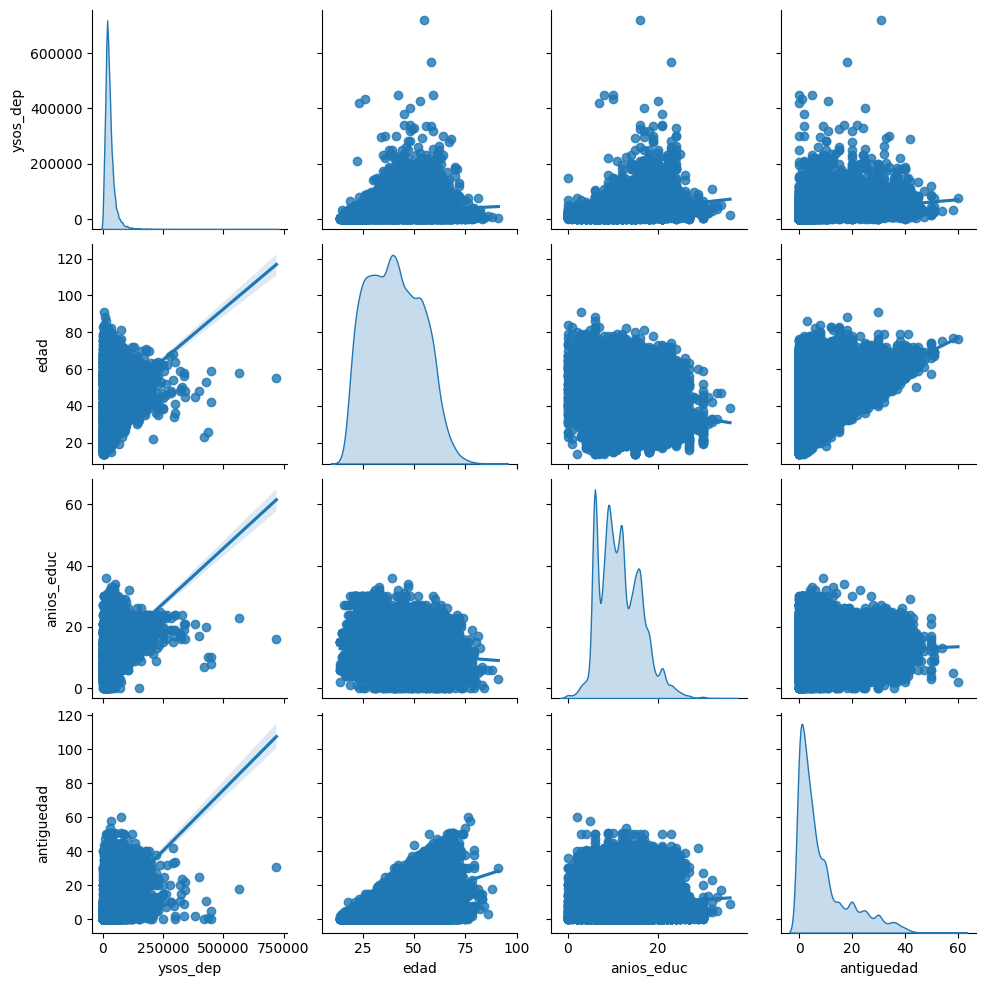

In [9]:
sns.pairplot(df_ysos, kind="reg", diag_kind="kde")

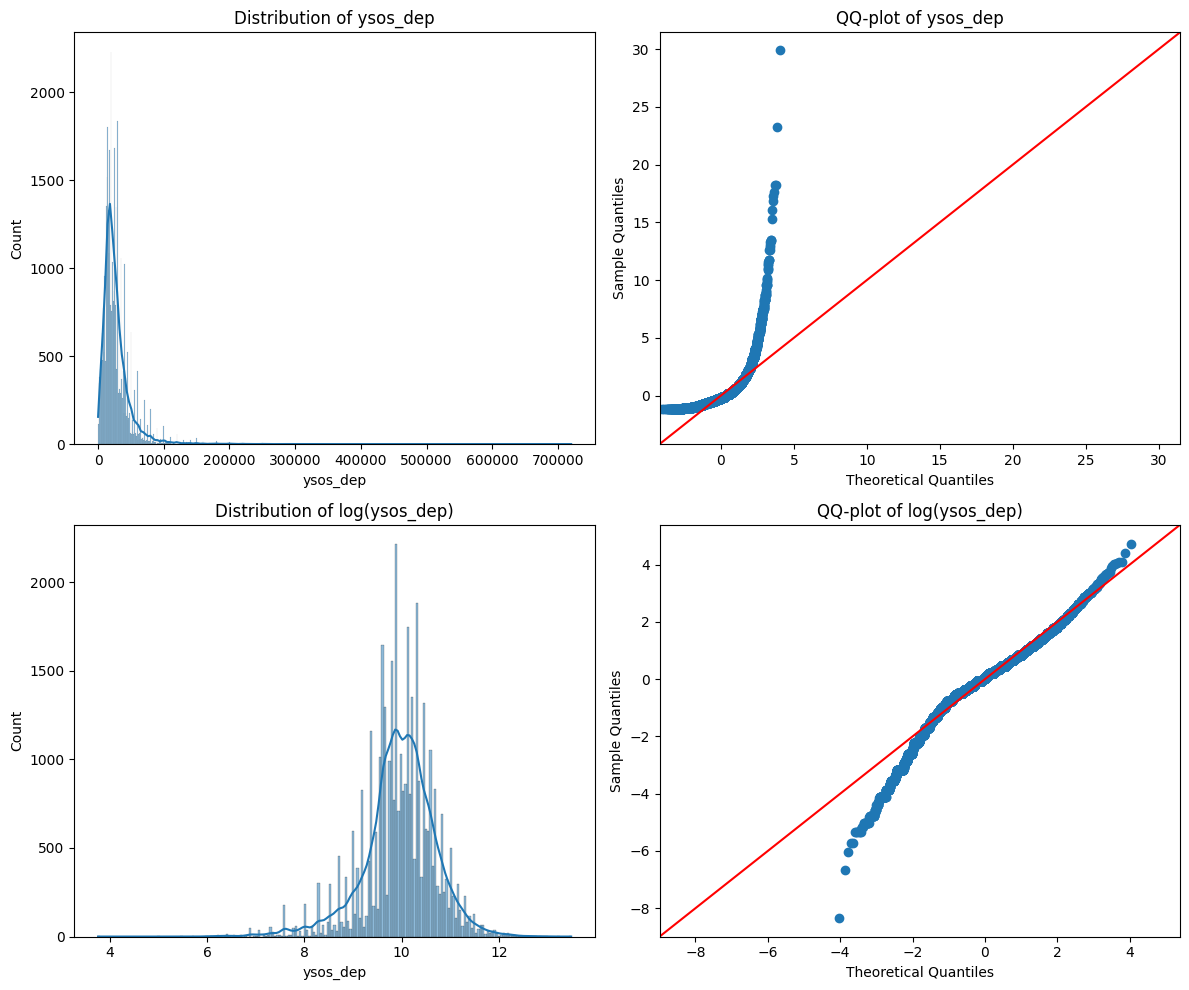

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Histogram of ysos_dep
sns.histplot(df_ysos['ysos_dep'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of ysos_dep')

# 2. QQ-plot of ysos_dep
sm.qqplot(np.array(df_ysos['ysos_dep']), line='45', fit=True, ax=axes[0, 1])
axes[0, 1].set_title('QQ-plot of ysos_dep')

# 3. Histogram of log(ysos_dep)
sns.histplot(np.log(df_ysos['ysos_dep']), kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of log(ysos_dep)')

# 4. QQ-plot of log(ysos_dep)
sm.qqplot(np.array(np.log(df_ysos['ysos_dep'])), line='45', fit=True, ax=axes[1, 1])
axes[1, 1].set_title('QQ-plot of log(ysos_dep)')

plt.tight_layout()
plt.show()

The QQ-Plot graphs show pairs of empirical and theoretical quantiles. To construct the points of the plot, the following steps are followed:

- The data are sorted from smallest to largest: x1, x2, ..., xn (assuming we have n data points).
- To calculate the theoretical quantiles associated with each value, an expected probability is first assigned to each data point using the formula: pi = (i-0.5)/n. With this probability pi, the value of the corresponding theoretical quantile is calculated as the inverse of the cumulative distribution function (in this case, of the standard normal).
- With these theoretical quantiles and the original data, the QQ-Plot is constructed. If the data have a distribution similar to the standard normal, the points align along the straight line with slope 1 (the 45-degree reference line). That is why this reference line is plotted.

In our case, the income values do not behave like a standard normal: the data are clustered to the left and there are extreme values to the right (positive skewness). That is why we chose to work with the logarithm of the values, which allows for a better "spread" of the data and brings them closer to normality. When plotting the histogram and QQ-plot of the logarithm of incomes, a distribution much closer to the standard normal is observed.

The QQ-plot is useful for visually diagnosing the normality of a variable. In this analysis, the original income variable shows a strong deviation from normality, while its logarithmic transformation fits much better to the normal distribution, which justifies its use in regression models.

In [11]:
df_ysos['l_ysos_dep'] = np.log(df_ysos['ysos_dep'])
df_l_ysos = df_ysos.drop(columns=['ysos_dep'])


<Figure size 1000x1500 with 0 Axes>

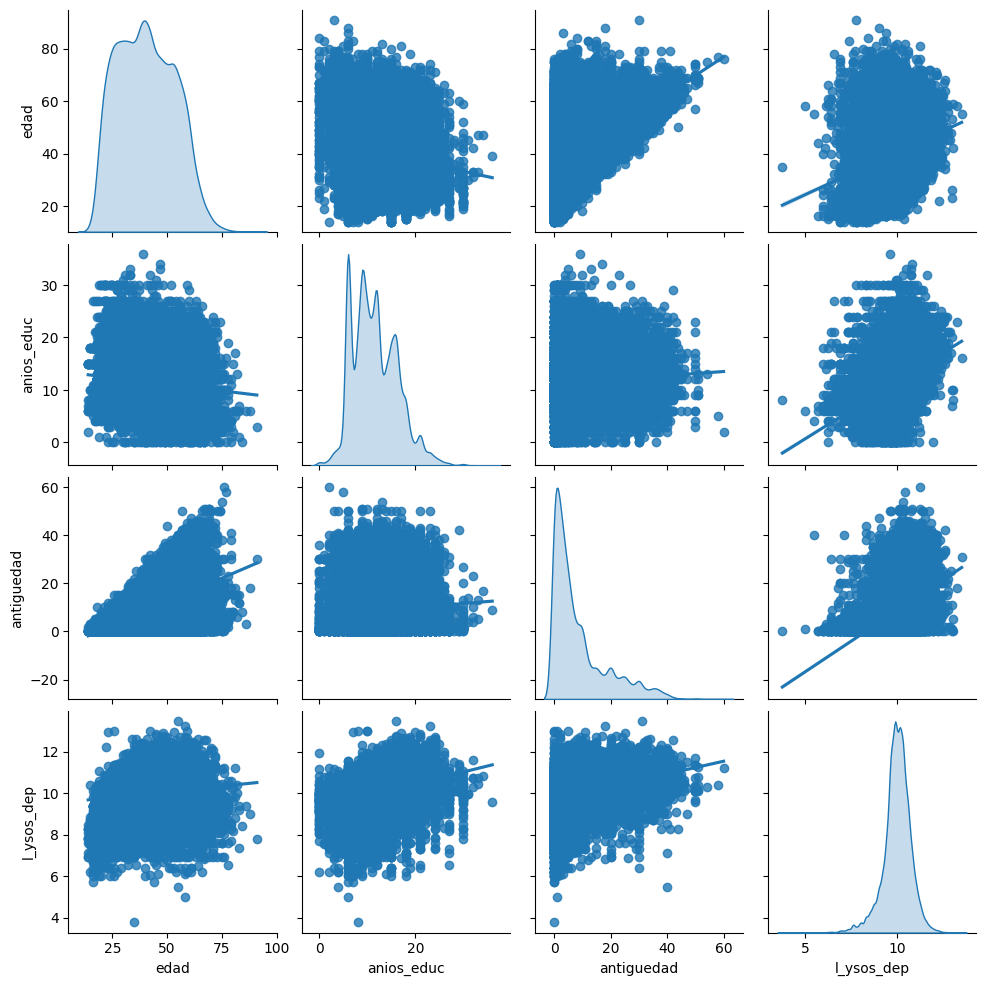

In [12]:
plt.figure(figsize=(10, 15))
sns.pairplot(df_l_ysos, kind="reg", diag_kind="kde")

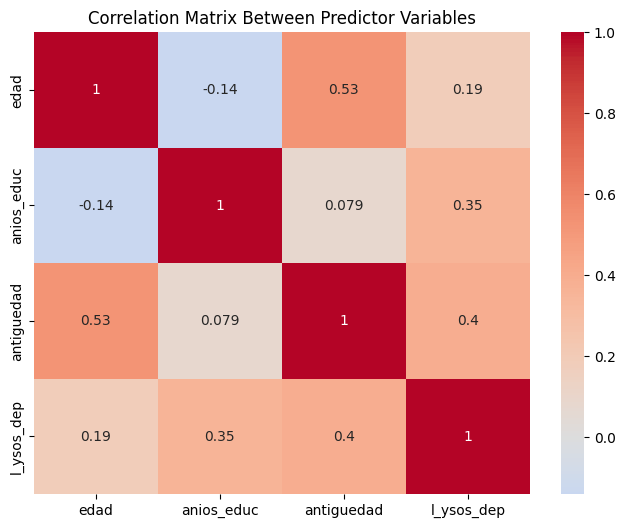

In [13]:
# Correlation matrix between predictor variables
numerical = df_l_ysos.select_dtypes(include=['number'])

# Pearson correlation
corr = numerical.corr()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix Between Predictor Variables")
plt.show()

The correlation matrix shows the strength and direction of linear relationships between numerical variables using the Pearson correlation coefficient. Values close to 1 indicate a strong positive correlation, values close to -1 indicate a strong negative correlation, and values close to 0 suggest little or no linear relationship. This analysis allows the identification of potential multicollinearity problems between variables, which can affect the stability and interpretation of linear models. If very high correlations are detected (for example, greater than 0.8 or less than -0.8), it is advisable to consider removing or combining variables.


In this case, we see that there is no clear correlation between numerical predictor variables. The highest absolute correlation coefficient is between seniority and years of education, with a value of 0.53. Regarding the correlation with the dependent variable, we observe that age, years of education, and seniority all have positive correlation values. As these variables increase, salary tends to rise.

<20: 14.19%
20-30: 40.35%
31-40: 23.57%
41-50: 13.84%
>50: 8.05%


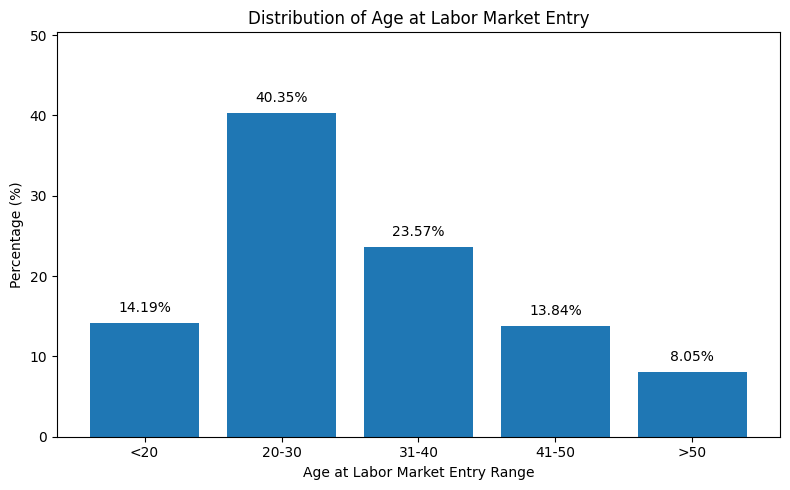

In [14]:
# Define age groups for labor market entry
bins = [0, 20, 30, 40, 50, df_ysos['edad'] .sub(df_ysos['antiguedad']).max()]
labels = ['<20', '20-30', '31-40', '41-50', '>50']

# Calculate age at labor market entry
df_ysos['age_at_entry'] = df_ysos['edad'] - df_ysos['antiguedad']
df_ysos['entry_age_group'] = pd.cut(df_ysos['age_at_entry'], bins=bins, labels=labels, right=True)

# Calculate percentage distribution by age group
percentages = df_ysos['entry_age_group'].value_counts(normalize=True).sort_index() * 100

for group, pct in percentages.items():
    print(f"{group}: {pct:.2f}%")

# Bar plot of the percentage distribution by age at labor market entry
plt.figure(figsize=(8, 5))
bars = plt.bar(percentages.index.astype(str), percentages.values, color="#1f77b4")

# Annotate percentages above bars
for bar, pct in zip(bars, percentages.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f"{pct:.2f}%", 
             ha='center', va='bottom', fontsize=10)

plt.xlabel('Age at Labor Market Entry Range')
plt.ylabel('Percentage (%)')
plt.title('Distribution of Age at Labor Market Entry')
plt.ylim(0, percentages.max() + 10)
plt.tight_layout()
plt.show()


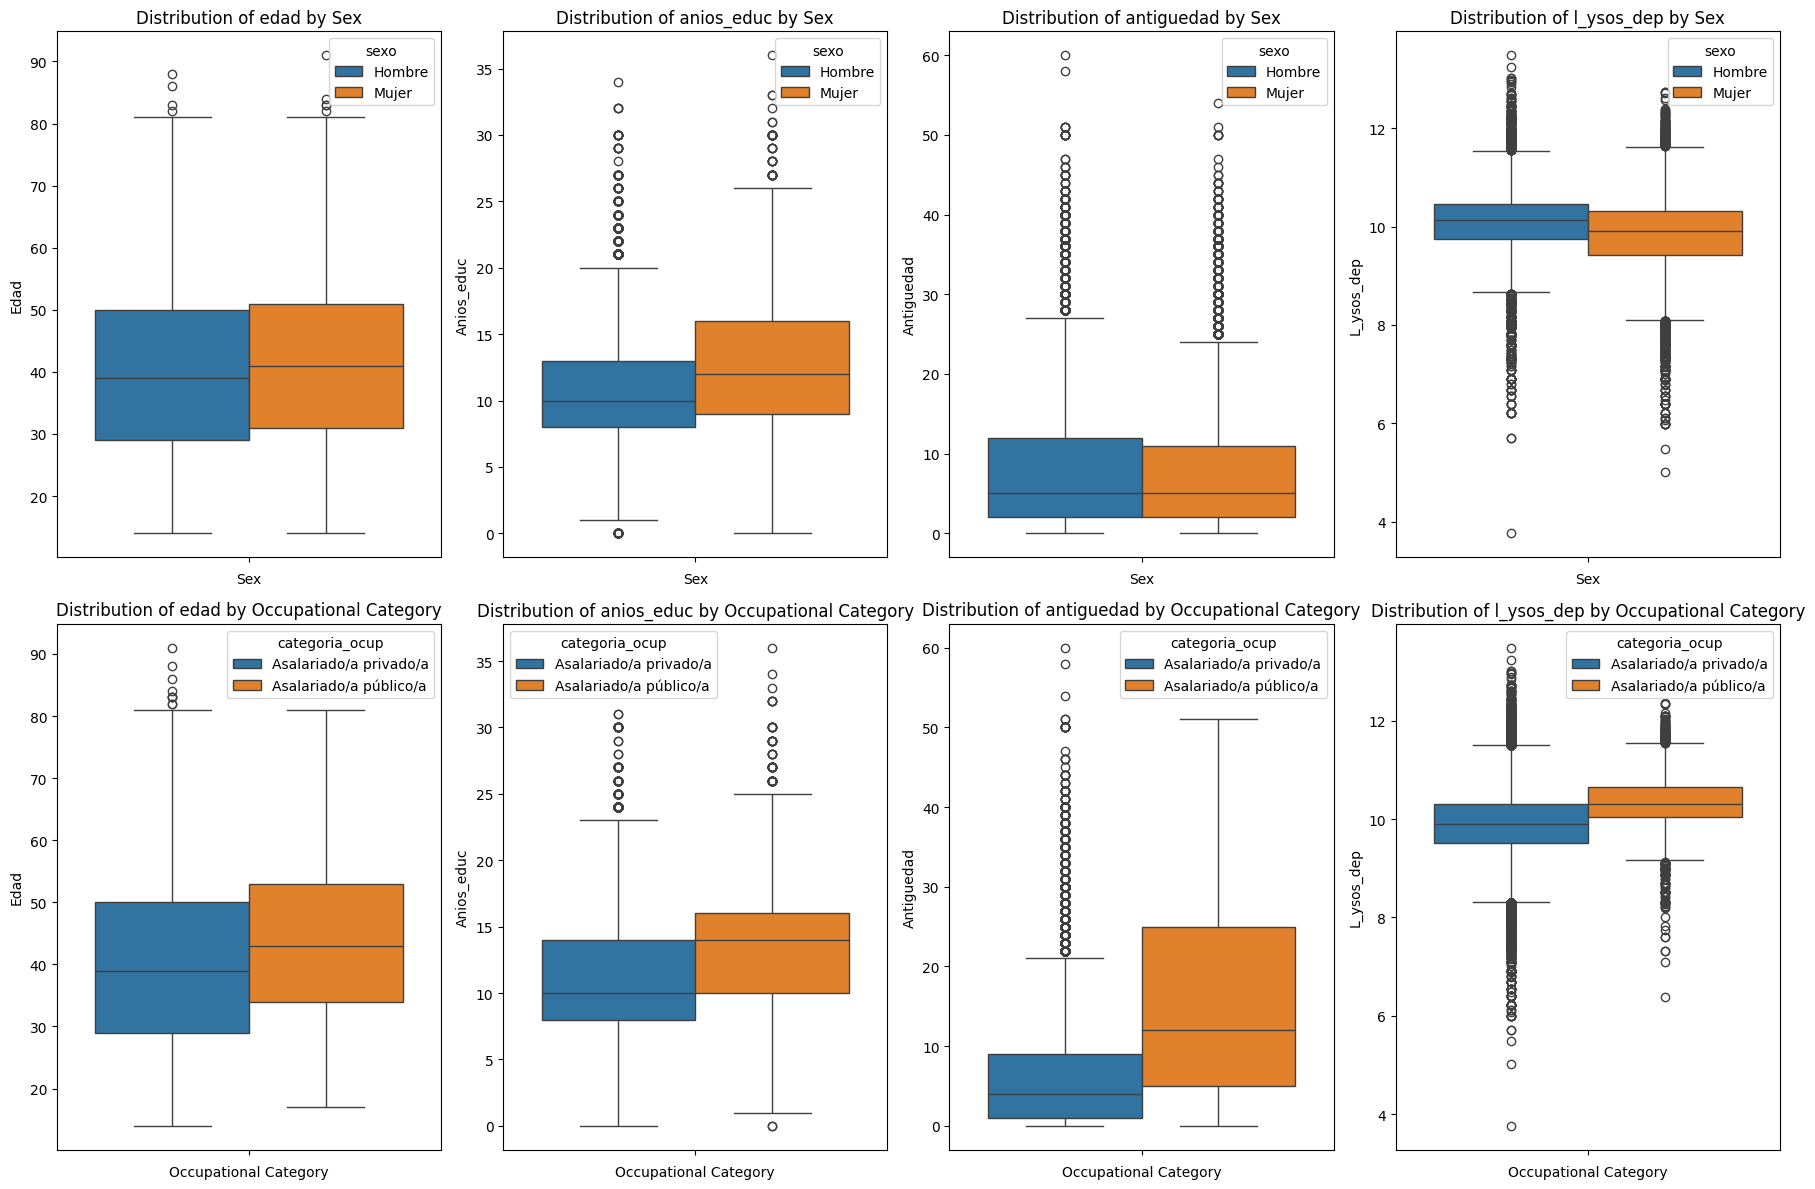

In [15]:
fig, axes = plt.subplots(2, 4, figsize=(18, 12))
colores = ['#1f77b4', '#ff7f0e']

# Top row: Boxplots by sex
for i, var in enumerate(['edad', 'anios_educ', 'antiguedad', 'l_ysos_dep']):
    sns.boxplot(data=df_l_ysos, y=var, hue='sexo', ax=axes[0, i])
    axes[0, i].set_title(f'Distribution of {var} by Sex')
    axes[0, i].set_xlabel('Sex')
    axes[0, i].set_ylabel(var.capitalize())

# Bottom row: Boxplots by occupational category
df_l_ysos['categoria_ocup'] = df_l_ysos['categoria_ocup'].cat.remove_unused_categories()
for i, var in enumerate(['edad', 'anios_educ', 'antiguedad', 'l_ysos_dep']):
    sns.boxplot(data=df_l_ysos, y=var, hue='categoria_ocup', ax=axes[1, i])
    axes[1, i].set_title(f'Distribution of {var} by Occupational Category')
    axes[1, i].set_xlabel('Occupational Category')
    axes[1, i].set_ylabel(var.capitalize())

plt.tight_layout()
plt.show()

*Three boxplots are created to compare the distribution of three numerical variables (age, years of education, and seniority) between men and women. This allows us to detect differences in central tendency (median), dispersion, and the presence of outliers by sex. For example, we can observe if there are gaps in age, educational level, or work experience according to sex, which can be useful for inequality analysis or labor profile segmentation.*

*The behavior of the three predictor variables is studied, segmented by sex. It is observed that women, a priori, have a higher educational level than men, while the other two variables behave similarly for both sexes.*

*This set of plots compares the distribution of three numerical variables —age, years of education, and seniority— according to the occupational category of the surveyed individuals. The function `remove_unused_categories()` is used to ensure that only the categories actually present in the data are shown.*

*Age: On average, public sector employees tend to be slightly older than private sector employees, with a higher median age and greater concentration in the upper ranges.*

*Years of education: Public sector employees have more years of education on average, with a distribution shifted toward higher values.*

*Seniority: Seniority is also notably higher in the public sector. The median years worked and the interquartile range are higher, suggesting greater stability or duration in public jobs compared to private ones.*

*Distribution of income (l_ysos_dep) by sex*

The plot shows a difference in income between men and women. On average, men have higher income levels (l_ysos_dep) than women. This disparity is reflected in both the median and the spread of the data.


In [16]:
categorical_columns = ['sexo', 'categoria_ocup']
numerical_columns = ['edad', 'anios_educ', 'antiguedad']

# función transformadora
column_transform = make_column_transformer(
    (OneHotEncoder(drop='if_binary'), categorical_columns), # cuando son dos categorías, elimina una
  # (StandardScaler(), numerical_columns), # comentado mientras no se decida estandarizar
    remainder='passthrough', # deja el resto de las columnas sin transformar
    verbose_feature_names_out=False)

In [17]:
df_l_ysos_transf = pd.DataFrame(
    column_transform.fit_transform(df_l_ysos), 
    columns=column_transform.get_feature_names_out()
)

df_l_ysos_transf.head()

,sexo_Mujer,categoria_ocup_Asalariado/a público/a,edad,anios_educ,antiguedad,l_ysos_dep
0,0.0,0.0,70.0,6.0,7.0,9.798127
1,0.0,1.0,52.0,6.0,32.0,10.778956
2,1.0,0.0,42.0,16.0,0.0,10.404263
3,1.0,0.0,29.0,8.0,1.0,7.783224
4,0.0,0.0,37.0,6.0,4.0,10.043249


### 2.3 Dataset partition: Train and Test

In a real-world scenario, we would not know the relationship between predictors and the outcome. Given a dataset, our task is to find suitable candidate models and choose the one that best fits our information.

To this end, we split our data into at least two distinct sets:
- Training set (train): the portion of data used to fit the model.
- Test set (test): the portion of data used to evaluate model performance.

**Since the test set contains data not previously seen by the model, evaluating performance on this set provides a better estimate of how the model would perform on unseen real-world data.**

To split our dataset, we use the library: **sklearn.model_selection.train_test_split()** whose parameters are:
   - arrays: sequence of indexables. Lists, numpy arrays, scipy-sparse matrices, and pandas dataframes are valid inputs.
   - test_size: int or float, default None. If float, should be between 0.0 and 1.0 and represents the proportion of the dataset to include in the test split. If int, it refers to the absolute number of test samples. If None, the complement of the train size is used. Will be set to 0.25 if train size is also None.
   - train_size: int or float, default None.
   - random_state: int, default None. Controls the shuffling applied to the data before splitting. Pass an int for reproducible output across multiple function calls.
   - shuffle: boolean, default True. Whether or not to shuffle the data before splitting. Stratify must be None if shuffle = False.
   - stratify: array-like, default None. If not None, data is split in a stratified fashion using this as the class labels.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df_l_ysos_transf[['edad', 'sexo_Mujer', 'anios_educ', 'antiguedad', 'categoria_ocup_Asalariado/a público/a']], \
                                                    df_l_ysos_transf['l_ysos_dep'], 
                                                    test_size=0.20, 
                                                    random_state=1234)

### 2.4 Linear Regression

This section introduces a simple linear regression model using years of education as the sole predictor of log-transformed labor income. It includes coefficient interpretation under a log-response assumption, evaluation metrics (R² and mean squared error), and visual diagnostics through residual plots and fitted regression lines. The analysis helps assess both predictive strength and model fit quality using a single explanatory variable.

Coefficients:  [0.05762114]
Intercept:  9.298664274869825
When only the response variable is log-transformed, the beta coefficient is interpreted as a variation of [5.93] % in the response variable for each unit change in the independent variable
R2 score: 0.1232945147026161
MSE train: 0.48400899248511037
MSE test: 0.4834283901748651


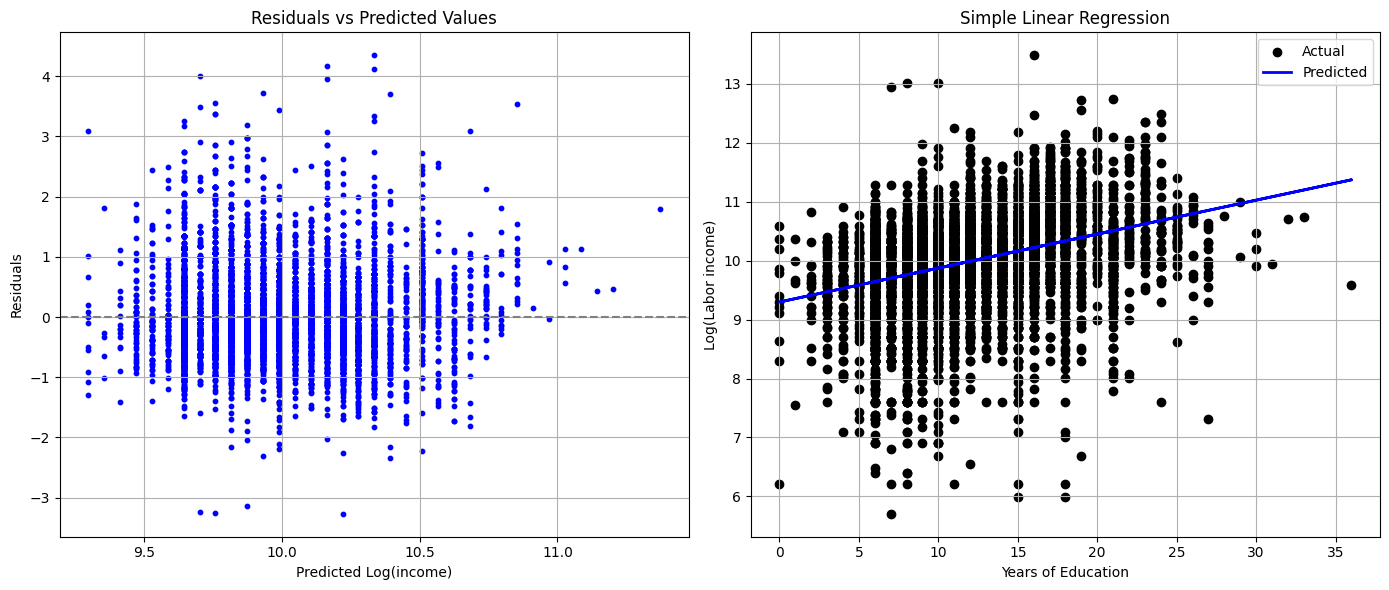

In [19]:
# Linear Regression

reg = LinearRegression()

mod1_X_train = X_train[['anios_educ']]
mod1_X_test = X_test[['anios_educ']]

mod1 = reg.fit(mod1_X_train, y_train)

# regression coefficients
print('Coefficients: ', mod1.coef_)
print('Intercept: ', mod1.intercept_ )

print('When only the response variable is log-transformed, the beta coefficient is interpreted as a variation of',
    np.around((np.exp(mod1.coef_)-1)*100, 2), '% in the response variable for each unit change in the independent variable')

# Coefficient of determination (R2)
print('R2 score:', mod1.score(mod1_X_test, y_test))

# prediction on train
mod1_y_train_pred = mod1.predict(mod1_X_train)

# prediction on test
mod1_y_test_pred = mod1.predict(mod1_X_test)

mod1_mse_train = mean_squared_error(y_train, mod1_y_train_pred)
print('MSE train:', mod1_mse_train)

mod1_mse_test = mean_squared_error(y_test, mod1_y_test_pred)
print('MSE test:', mod1_mse_test)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Residuals Plot
axes[0].scatter(mod1.predict(mod1_X_test), mod1.predict(mod1_X_test) - y_test,
                color="blue", s=10, label="Test data")
axes[0].axhline(y=0, color="gray", linestyle="--")
axes[0].set_xlabel("Predicted Log(income)")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs Predicted Values")
axes[0].grid(True)

# Regression Line Plot
axes[1].scatter(mod1_X_test, y_test, color="black", label="Actual")
axes[1].plot(mod1_X_test, mod1_y_test_pred, color="blue", linewidth=2, label="Predicted")
axes[1].set_xlabel("Years of Education")
axes[1].set_ylabel("Log(Labor income)")
axes[1].set_title("Simple Linear Regression")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


### 2.5 Polynomical Regression

This section explores the impact of polynomial regression on predicting labor income using single-variable models. It begins with a degree-2 polynomial fit for years of education, followed by a broader analysis for three predictors: age, education, and tenure. For each variable, models ranging from degree 1 to 15 are evaluated with metrics such as MSE and R² to assess both fit quality and potential overfitting. Visualizations include fitted curves and diagnostic plots for error and explained variance across degrees.

In [20]:
from sklearn.preprocessing import PolynomialFeatures

# Train the model using training sets (polynomial degree 2)
mod2_X_train = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X_train[['anios_educ']])
mod2_X_test = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X_test[['anios_educ']])

mod2 = reg.fit(mod2_X_train, y_train)

print("=== Polynomial Regression (Degree 2) ===")
print(f"Coefficients: {mod2.coef_}")
print(f"Intercept: {mod2.intercept_}")

# Coefficient interpretation
print("\nInterpretation:")
print("Intercept is the expected log(income) when all predictors are zero.")
print("Coefficients correspond to the linear and quadratic terms of 'anios_educ'.")

# R2 score
r2 = mod2.score(mod2_X_test, y_test)
print(f"\nR² score on test set: {r2:.4f} (explained variance)")

# Predictions
mod2_y_train_pred = mod2.predict(mod2_X_train)
mod2_y_test_pred = mod2.predict(mod2_X_test)

# MSE
mod2_mse_train = mean_squared_error(y_train, mod2_y_train_pred)
mod2_mse_test = mean_squared_error(y_test, mod2_y_test_pred)
print(f"MSE (train): {mod2_mse_train:.4f}")
print(f"MSE (test):  {mod2_mse_test:.4f}")

print("\nLower MSE indicates better fit. Compare train vs test MSE to assess overfitting.")

=== Polynomial Regression (Degree 2) ===
Coefficients: [ 0.1030542  -0.00177063]
Intercept: 9.047575482410274

Interpretation:
Intercept is the expected log(income) when all predictors are zero.
Coefficients correspond to the linear and quadratic terms of 'anios_educ'.

R² score on test set: 0.1266 (explained variance)
MSE (train): 0.4814
MSE (test):  0.4816

Lower MSE indicates better fit. Compare train vs test MSE to assess overfitting.



------------------------------------------------------------
Using 'edad' as the only predictor variable
------------------------------------------------------------

    degree  mse_train  mse_test  r2_train   r2_test
0        1   0.534154  0.533794  0.035987  0.031955
1        2   0.498546  0.496235  0.100249  0.100070
2        3   0.497228  0.493699  0.102628  0.104668
3        4   0.492713  0.487534  0.110778  0.115850
4        5   0.490520  0.485127  0.114735  0.120214
5        6   0.491299  0.486403  0.113329  0.117900
6        7   0.493966  0.489949  0.108516  0.111470
7        8   0.498695  0.495887  0.099982  0.100700
8        9   0.504694  0.503154  0.089155  0.087522
9       10   0.510870  0.510358  0.078009  0.074458
10      11   0.516500  0.516640  0.067849  0.063064
11      12   0.521330  0.521781  0.059132  0.053741
12      13   0.525380  0.525899  0.051822  0.046273
13      14   0.528773  0.529208  0.045697  0.040272
14      15   0.531651  0.531914  0.040505  0.035364


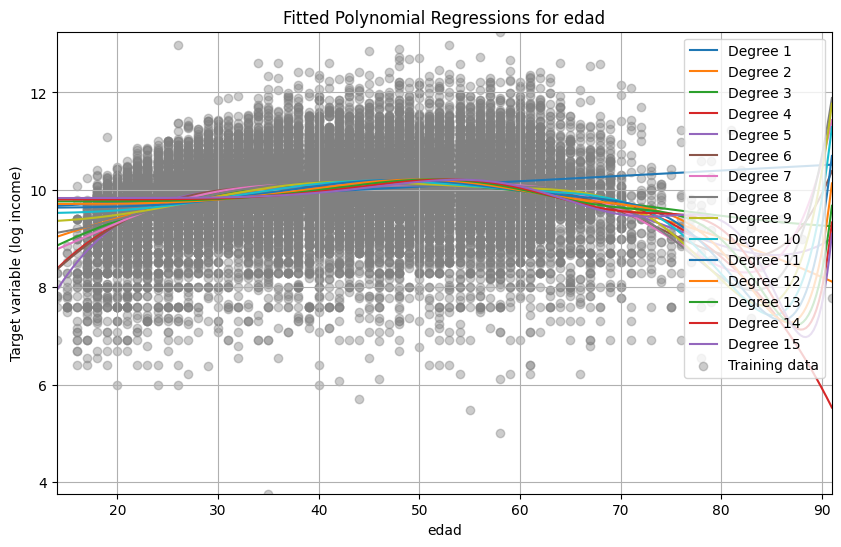

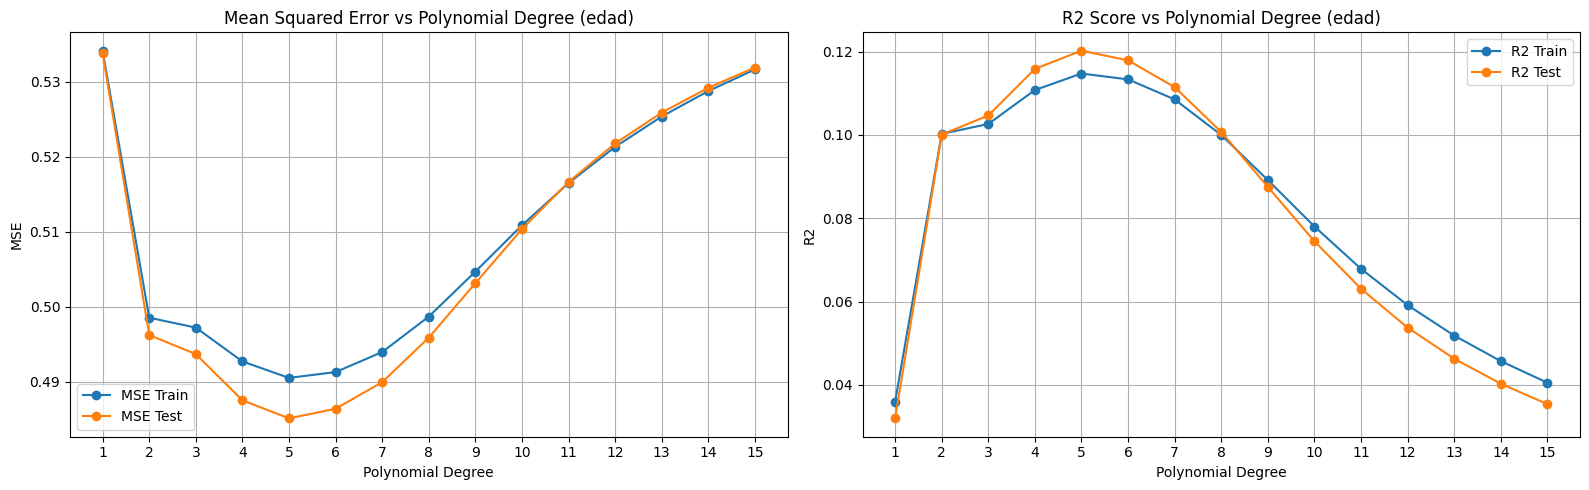


------------------------------------------------------------
Using 'anios_educ' as the only predictor variable
------------------------------------------------------------

    degree  mse_train  mse_test  r2_train   r2_test
0        1   0.484009  0.483428  0.126486  0.123295
1        2   0.481445  0.481594  0.131114  0.126621
2        3   0.479473  0.480003  0.134673  0.129506
3        4   0.479457  0.479908  0.134701  0.129679
4        5   0.479386  0.479597  0.134830  0.130244
5        6   0.479269  0.480581  0.135040  0.128458
6        7   0.479245  0.480007  0.135085  0.129500
7        8   0.479280  0.481199  0.135020  0.127337
8        9   0.479522  0.481117  0.134584  0.127486
9       10   0.479829  0.481652  0.134029  0.126516
10      11   0.480299  0.479742  0.133181  0.129980
11      12   0.480987  0.513278  0.131940  0.069162
12      13   0.482134  0.736567  0.129869 -0.335776
13      14   0.497376  1.738683  0.102362 -2.153131
14      15   0.504439  2.448599  0.089616 -3.4

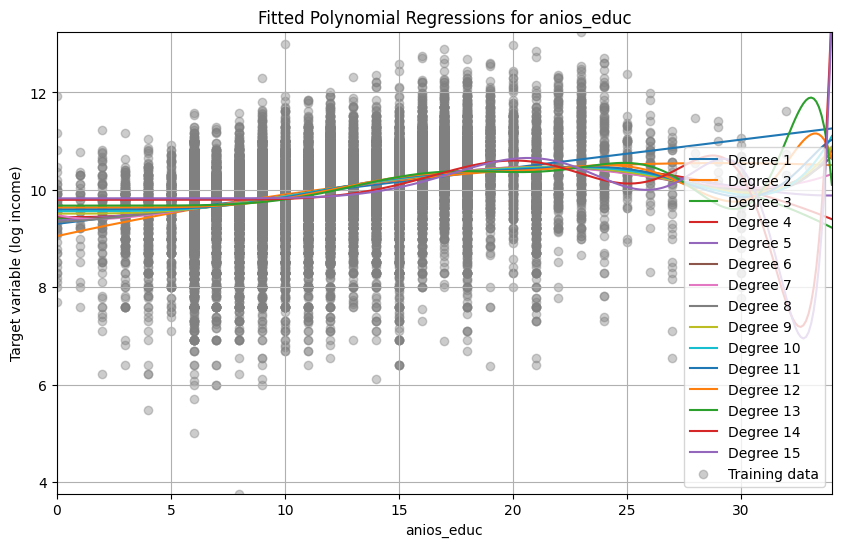

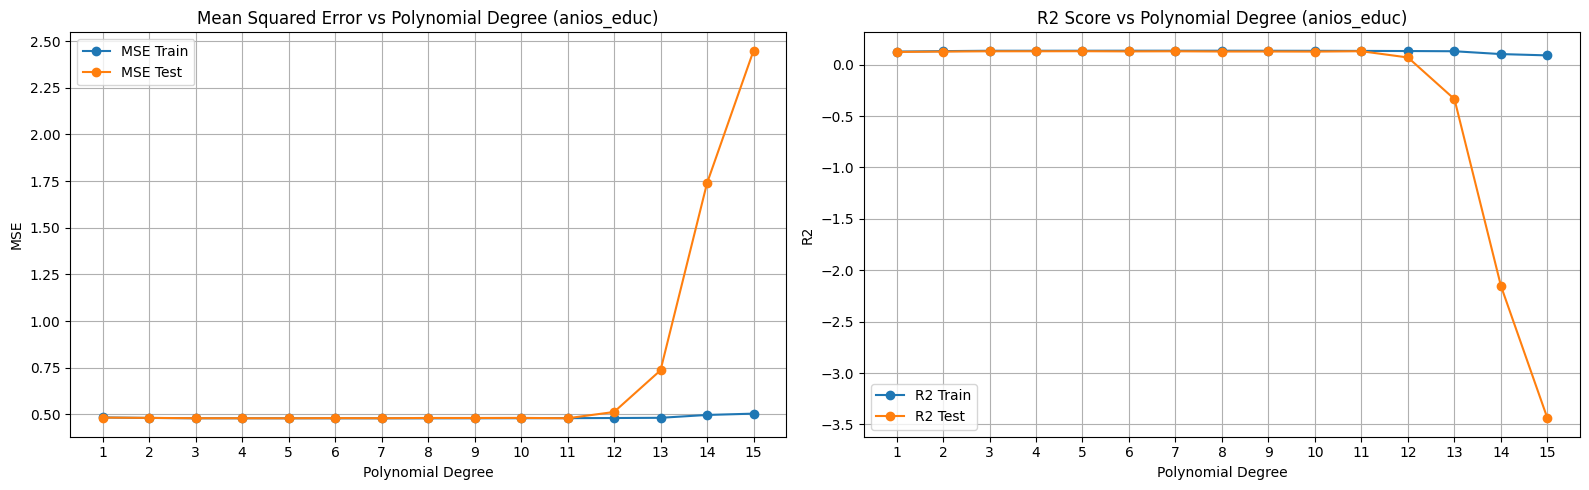


------------------------------------------------------------
Using 'antiguedad' as the only predictor variable
------------------------------------------------------------

    degree  mse_train  mse_test  r2_train   r2_test
0        1   0.466348  0.468965  0.158359  0.149524
1        2   0.453242  0.456975  0.182012  0.171268
2        3   0.447528  0.453942  0.192326  0.176768
3        4   0.444998  0.451202  0.196890  0.181738
4        5   0.444357  0.450635  0.198047  0.182765
5        6   0.444318  0.450578  0.198119  0.182869
6        7   0.444203  0.450601  0.198327  0.182828
7        8   0.460955  0.465092  0.168092  0.156548
8        9   0.472691  0.476926  0.146913  0.135087
9       10   0.497307  0.498409  0.102486  0.096126
10      11   0.503154  0.506395  0.091934  0.081644
11      12   0.508264  0.515349  0.082712  0.065405
12      13   0.512790  0.525133  0.074543  0.047663
13      14   0.516777  0.535464  0.067348  0.028928
14      15   0.520282  0.546748  0.061022  0.0

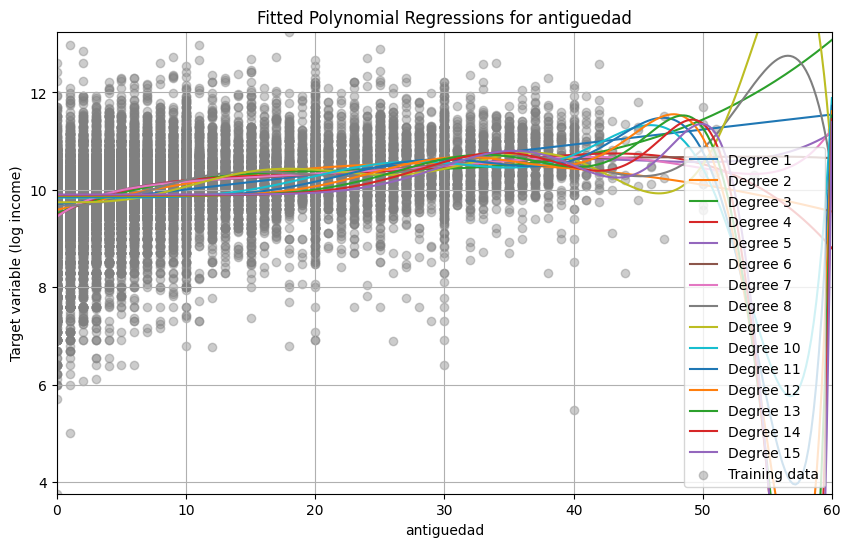

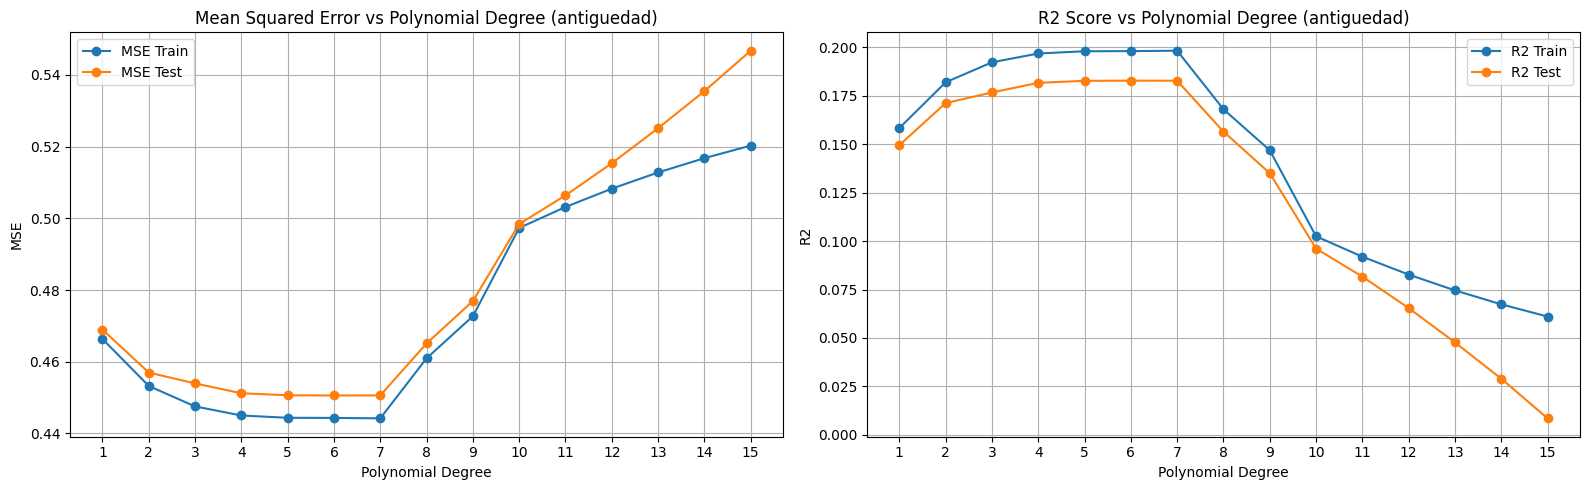

In [21]:
import matplotlib.gridspec as gridspec

variables = ['edad', 'anios_educ', 'antiguedad']

for var in variables:
    print("\n" + "-"*60)
    print(f"Using '{var}' as the only predictor variable")
    print("-"*60 + "\n")
    results = []
    for degree in range(1, 16):
        mod_X_train = PolynomialFeatures(degree=degree, include_bias=False).fit_transform(X_train[[var]])
        mod_X_test = PolynomialFeatures(degree=degree, include_bias=False).fit_transform(X_test[[var]])
        model = reg.fit(mod_X_train, y_train)
        y_train_pred = model.predict(mod_X_train)
        y_test_pred = model.predict(mod_X_test)
        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)
        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)
        results.append({
            'degree': degree,
            'mse_train': mse_train,
            'mse_test': mse_test,
            'r2_train': r2_train,
            'r2_test': r2_test,
            'coefficients': model.coef_,
            'intercept': model.intercept_
        })
    # Convert to DataFrame
    df_results = pd.DataFrame(results)
    print(df_results[['degree', 'mse_train', 'mse_test', 'r2_train', 'r2_test']])

    # Plot fitted polynomials for each degree
    plt.figure(figsize=(10, 6))
    X_range = np.linspace(X_train[var].min(), X_train[var].max(), 300)
    for res in results:
        degree = res['degree']
        coefs = res['coefficients']
        intercept = res['intercept']
        # Evaluate polynomial manually
        y_pred = sum([coefs[i] * X_range**(i + 1) for i in range(len(coefs))]) + intercept
        plt.plot(X_range, y_pred, label=f'Degree {degree}')
    # Actual data
    plt.scatter(X_train[var], y_train, color='gray', alpha=0.4, label='Training data')
    plt.title(f'Fitted Polynomial Regressions for {var}')
    plt.xlabel(var)
    plt.ylabel('Target variable (log income)')
    plt.legend()
    plt.grid(True)
    plt.xlim(X_train[var].min(), X_train[var].max())
    plt.ylim(y_train.min(), y_train.max())
    plt.show()

    # Plot MSE and R2 side by side
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    # MSE plot
    axes[0].plot(df_results['degree'], df_results['mse_train'], marker='o', label='MSE Train')
    axes[0].plot(df_results['degree'], df_results['mse_test'], marker='o', label='MSE Test')
    axes[0].set_title(f'Mean Squared Error vs Polynomial Degree ({var})')
    axes[0].set_xlabel('Polynomial Degree')
    axes[0].set_ylabel('MSE')
    axes[0].legend()
    axes[0].grid(True)
    axes[0].set_xticks(df_results['degree'])
    # R2 plot
    axes[1].plot(df_results['degree'], df_results['r2_train'], marker='o', label='R2 Train')
    axes[1].plot(df_results['degree'], df_results['r2_test'], marker='o', label='R2 Test')
    axes[1].set_title(f'R2 Score vs Polynomial Degree ({var})')
    axes[1].set_xlabel('Polynomial Degree')
    axes[1].set_ylabel('R2')
    axes[1].legend()
    axes[1].grid(True)
    axes[1].set_xticks(df_results['degree'])
    plt.tight_layout()
    plt.show()


#### 2.5.1 Analysis of Polynomial Regressions and Overfitting

Variable: `anios_educ`
The model improves slightly up to degree 5. From there, the test MSE increases sharply while the training MSE continues to decrease. The test R² even becomes negative at high degrees, which shows poor performance. This indicates strong overfitting: the model learns too much from the training data and loses its ability to generalize.

Variable: `edad`

The fit improves very little as the degree increases. Both MSE and R² improve very slowly and stabilize from degree 5-6 onwards. There are no signs of overfitting, but also no clear benefits. The relationship with the target variable appears almost linear.

Variable: `antiguedad`

There is a sustained improvement up to degree 6-7. Afterwards, the metrics stabilize without drastic changes. There is a slight sign of overfitting at very high degrees.

In conclusion, to avoid overfitting it is key not to increase the polynomial degree indiscriminately. Given the nature of the data, where the range of salaries is very wide for each predictor variable, increasing the degree of the polynomial does not improve the model. It can be seen in the graph that despite increasing the degree, the function's domain coverage is practically the same.

### 2.6 Linear Regression with all base model variables

This section presents a multiple linear regression model using all available predictors to estimate log-transformed labor income. It leverages the statsmodels library for detailed summary statistics, including coefficient significance and model fit diagnostics. Visual analysis is focused on the predictor 'anios_educ', with regression plots illustrating linear relationships and residual patterns. The model's performance is evaluated through mean squared error on both training and test sets, offering insights into generalization and potential overfitting.

                            OLS Regression Results                            
Dep. Variable:             l_ysos_dep   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     2969.
Date:                Mon, 21 Jul 2025   Prob (F-statistic):               0.00
Time:                        20:23:30   Log-Likelihood:                -27581.
No. Observations:               29908   AIC:                         5.517e+04
Df Residuals:                   29902   BIC:                         5.522e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

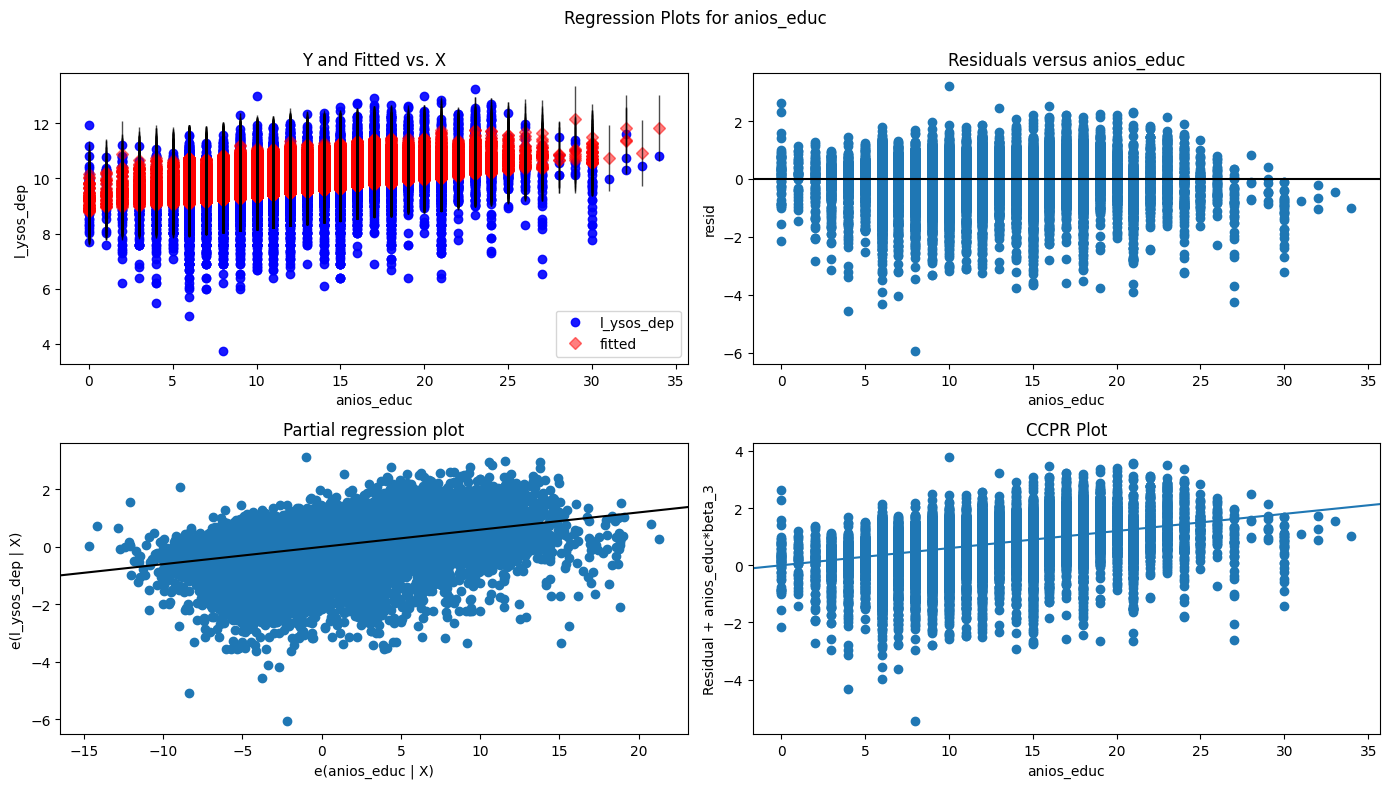

In [22]:
# Multiple linear model with statsmodels and regression visualization for 'anios_educ'

# Define response and predictor variables
mod3_y_train = y_train
mod3_y_test = y_test
mod3_X_train = X_train
mod3_X_test = X_test

# Add constant to predictors
mod3_X_train = sm.add_constant(mod3_X_train)
mod3_X_test = sm.add_constant(mod3_X_test)

# Fit the linear regression model
mod3 = sm.OLS(mod3_y_train, mod3_X_train).fit()

# Show model summary
print(mod3.summary())

# Regression visualization for 'anios_educ'
fig = plt.figure(figsize=(14, 8))
fig = sm.graphics.plot_regress_exog(mod3, 'anios_educ', fig=fig)

# Prediction on train and test
mod3_y_train_pred = mod3.predict(mod3_X_train)
mod3_y_test_pred = mod3.predict(mod3_X_test)

# Calculate and show MSE on train and test
mod3_mse_train = mean_squared_error(mod3_y_train, mod3_y_train_pred)
mod3_mse_test = mean_squared_error(mod3_y_test, mod3_y_test_pred)
print(f"MSE train: {mod3_mse_train:.4f}")
print(f"MSE test: {mod3_mse_test:.4f}")

##  3. Linear Regression with additional variables

This section implements a comprehensive multiple linear regression model using a transformed and enriched dataset. It includes:

- Renaming and integrating key variables to improve semantic clarity.
- Deriving a medical coverage level from multiple binary indicators, weighted by coverage type.
- Mapping occupational codes to broader categories to enable interpretability.
- Encoding categorical variables and scaling numericals for regression modeling.
- Splitting data for training and testing, followed by fitting an OLS model.
- Evaluating model performance using mean squared error in both log and original income scales.

This workflow enhances predictive modeling by combining domain-informed feature engineering with robust linear regression diagnostics. Let me know if you’d like to visualize coefficient importance or expand on group-level effects.

In [23]:
# Create a copy of the DataFrame df_l_ysos to avoid modifying the original
df_m5 = df_l_ysos.copy()

# Define a dictionary mapping original column names to more descriptive names
posibles_variables = {
    'f71_2': 'codigo_trabajo',           # Job code
    'estred13': 'estrato',              # Socioeconomic stratum
    'f79': 'medio_de_transp',           # Means of transportation
    'f85': 'h_trabajadas_p_sem',      # Hours worked per week
    'region_3': 'area_geografica',      # Geographic area
    'e45_1': 'MSP',                     # Public Health Service
    'e45_2': 'Mutualista',              # Mutual health insurance
    'e45_3': 'Seguro_privado',          # Private insurance
    'e45_4': 'FF.AA.',                 # Armed Forces health service
    'e45_5': 'Policía',                 # Police health service
    'e45_6': 'Clínicas',                # Private clinics
    'e45_7': 'Otro_serv_med',           # Other medical services
    'e186_1': 'Cantidad_hijos_viven_hogar',  # Number of children living in the household
    'e560': 'Recibe_alguna_tarjeta',    # Receives some type of card (e.g., social benefits)
}

# Select columns from dfP2017 using the keys from posibles_variables, rename them, and join to df_m5
columnas_a_agregar = dfP2017[list(posibles_variables.keys())].rename(columns=posibles_variables)
df_m5 = df_m5.join(columnas_a_agregar)

# Define a list of columns related to medical coverage
cols_cobertura = [
    'MSP',
    'Mutualista',
    'Seguro_privado',
    'FF.AA.',
    'Policía',
    'Clínicas',
    'Otro_serv_med'
]

# Convert categorical "Sí" (Yes) to 1 and other values to 0 in medical coverage columns, and cast to integer type
df_m5[cols_cobertura] = df_m5[cols_cobertura].applymap(lambda x: 1 if x == "Sí" else 0).astype(int)

# Define weights for each medical coverage type to calculate a coverage level
pesos = [1, 2, 3, 2, 2, 1, 1]

# Calculate the medical coverage level by multiplying each column by its weight and taking the maximum value
df_m5['nivel_cobertura_medica'] = df_m5[cols_cobertura].multiply(pesos, axis=1).max(axis=1)
df_m5['nivel_cobertura_medica'] = np.where(df_m5['nivel_cobertura_medica'] == 0, 1, df_m5['nivel_cobertura_medica'])

# Drop the original medical coverage columns as they are summarized in nivel_cobertura_medica
df_m5 = df_m5.drop(columns=cols_cobertura)

# Extract the first digit from 'codigo_trabajo' to represent the main occupational group
df_m5['g_o'] = df_m5['codigo_trabajo'].astype(str).str[0]

# Define a dictionary to map the first digit to readable occupational group names in Spanish
mapeo_grandes_grupos = {
    '0': 'FFAA',  # Armed Forces
    '1': 'Poder ejecutivo',  # Executive Power
    '2': 'Profesionales científicos',  # Scientific Professionals
    '3': 'Profesionales de nivel medio',  # Mid-level Professionals
    '4': 'Empleados de oficina',  # Office Employees
    '5': 'Servicios, comercios y mercados',  # Services, Commerce, and Markets
    '6': 'Agricultores, agropecuarios y pesqueros',  # Farmers, Agricultural, and Fisheries Workers
    '7': 'Oficiales, operarios y otros oficios',  # Craftsmen, Operators, and Other Trades
    '8': 'Operadores de instalaciones y máquinas',  # Facility and Machine Operators
    '9': 'Trabajadores no calificados'  # Unskilled Workers
}

# Map the 'g_o' column values to the descriptive names, filling missing values with 'Otro / Sin clasificación' (Other / Unclassified)
df_m5['g_o'] = df_m5['g_o'].map(mapeo_grandes_grupos).fillna('Otro / Sin clasificación')

# Drop the original 'codigo_trabajo' column as it is no longer needed
df_m5 = df_m5.drop(columns=['codigo_trabajo'])

# Display the first 5 rows of the modified DataFrame
display(df_m5.head())

C:\Users\aledi\AppData\Local\Temp\ipykernel_22056\2943819504.py:38: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_m5[cols_cobertura] = df_m5[cols_cobertura].applymap(lambda x: 1 if x == "Sí" else 0).astype(int)


,edad,sexo,anios_educ,antiguedad,categoria_ocup,l_ysos_dep,estrato,medio_de_transp,h_trabajadas_p_sem,area_geografica,Cantidad_hijos_viven_hogar,Recibe_alguna_tarjeta,nivel_cobertura_medica,g_o
0,70.0,Hombre,6.0,7.0,Asalariado/a privado/a,9.798127,Montevideo Bajo,Transporte colectivo,44.0,Montevideo,0.0,No,2,"Servicios, comercios y mercados"
2,52.0,Hombre,6.0,32.0,Asalariado/a público/a,10.778956,Costa Este,A pie,60.0,Localidades urbanas de 5.000 habitantes o más,0.0,No,2,Operadores de instalaciones y máquinas
5,42.0,Mujer,16.0,0.0,Asalariado/a privado/a,10.404263,Montevideo Alto,Automóvil particular,40.0,Montevideo,1.0,No,2,"Servicios, comercios y mercados"
7,29.0,Mujer,8.0,1.0,Asalariado/a privado/a,7.783224,Montevideo Bajo,A pie,8.0,Montevideo,3.0,No,1,Trabajadores no calificados
8,37.0,Hombre,6.0,4.0,Asalariado/a privado/a,10.043249,Montevideo Bajo,Ciclomotor,60.0,Montevideo,0.0,No,2,"Agricultores, agropecuarios y pesqueros"


We created a copy of the main dataset to work safely (df_m5). Then, we defined a dictionary that translates raw or encoded variable names into more descriptive names, facilitating subsequent analysis. Using this dictionary, columns from the original dataset (dfP2017) are selected, renamed, and added to df_m5.

Additionally, we modified the variables related to medical coverage (from "Yes"/"No" responses to binary values) and constructed a synthetic indicator called nivel_cobertura_medica, which weights the relative importance of each type of coverage using a weighting system. Finally, the original medical coverage variables are removed, leaving only the aggregated variable.

The overall goal is to prepare and enrich the dataset with new descriptive variables to facilitate further analysis or modeling.

In [24]:
# Prepare the dataset
# Select categorical and numerical columns automatically
categorical_columns = df_m5.select_dtypes(include=['object', 'category']).columns.tolist()  # Identify columns with object or category data types
numerical_columns = df_m5.select_dtypes(include=['int64', 'float64']).columns.tolist()  # Identify columns with integer or float data types
numerical_columns = [col for col in numerical_columns if col != 'l_ysos_dep']  # Exclude 'l_ysos_dep' from numerical columns

# Define a column transformer function
column_transform = make_column_transformer(
    (OneHotEncoder(drop='first', sparse_output=False), categorical_columns),  # Apply OneHotEncoder to categorical columns, dropping the first category to avoid multicollinearity
    (StandardScaler(), numerical_columns),  # Apply StandardScaler to numerical columns (commented out while deciding whether to standardize)
    remainder='passthrough',  # Pass through any remaining columns without transformation
    verbose_feature_names_out=False  # Use concise feature names in the output
)

# Perform the transformation and create a new DataFrame
df_m5_transf = pd.DataFrame(
    column_transform.fit_transform(df_m5),  # Apply the transformations to the dataset
    columns=column_transform.get_feature_names_out()  # Use the transformed feature names as column names
)


In [25]:
# Select all columns except 'l_ysos_dep' as predictor variables
X = df_m5_transf.drop(columns=['l_ysos_dep'])  # Create feature matrix X by dropping the target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,  # Feature matrix
    df_m5_transf['l_ysos_dep'],  # Target variable
    test_size=0.20,  # Allocate 20% of data for testing
    random_state=1234  # Set random seed for reproducibility
)

# Define response variable for training and testing
mod5_y_train = y_train  # Assign training target variable
mod5_y_test = y_test  # Assign testing target variable

# Define predictor variables for training and testing
mod5_X_train = X_train  # Assign training feature matrix
mod5_X_test = X_test  # Assign testing feature matrix

# Add a constant term to predictor variables for the intercept in the regression model
mod5_X_train = sm.add_constant(mod5_X_train)  # Add constant column to training features
mod5_X_test = sm.add_constant(mod5_X_test)  # Add constant column to testing features

# Fit a linear regression model using Ordinary Least Squares (OLS)
mod5 = sm.OLS(mod5_y_train, mod5_X_train).fit()  # Fit the OLS model to the training data

# View the summary of the regression model
print(mod5.summary())  # Print detailed model statistics (coefficients, p-values, R-squared, etc.)

# Make predictions on the training set
mod5_y_train_pred = mod5.predict(mod5_X_train)  # Predict target values for training data

# Make predictions on the testing set
mod5_y_test_pred = mod5.predict(mod5_X_test)  # Predict target values for testing data

# Calculate Mean Squared Error (MSE) for training predictions
mod5_mse_train = mean_squared_error(mod5_y_train, mod5_y_train_pred)  # Compute MSE for training set
print(mod5_mse_train)  # Print training MSE

# Calculate Mean Squared Error (MSE) for testing predictions
mod5_mse_test = mean_squared_error(mod5_y_test, mod5_y_test_pred)  # Compute MSE for testing set
print(mod5_mse_test)  # Print testing MSE

# Apply exponential transformation to predictions and actual values to compute MSE and RMSE in original scale (pesos)
mod5_mse_train_trad = mean_squared_error(np.exp(mod5_y_train), np.exp(mod5_y_train_pred))  # Compute MSE on exponentiated training data
print(f'MSE train is {round(mod5_mse_train_trad, 2)}, which translates to {round(np.sqrt(mod5_mse_train_trad), 2)} pesos')  # Print training MSE and RMSE in pesos

# Compute MSE and RMSE for testing set in original scale (pesos)
mod5_mse_test_trad = mean_squared_error(np.exp(mod5_y_test), np.exp(mod5_y_test_pred))  # Compute MSE on exponentiated testing data
print(f'MSE test is {round(mod5_mse_test_trad, 2)}, which translates to {round(np.sqrt(mod5_mse_test_trad), 2)} pesos')  # Print testing MSE and RMSE in pesos

                            OLS Regression Results                            
Dep. Variable:             l_ysos_dep   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     1239.
Date:                Mon, 21 Jul 2025   Prob (F-statistic):               0.00
Time:                        20:23:32   Log-Likelihood:                -19455.
No. Observations:               29908   AIC:                         3.899e+04
Df Residuals:                   29869   BIC:                         3.931e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                                                                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

## 4. Cross validation

This section evaluates the stability and generalization of a linear regression model using 10-fold cross-validation. The workflow includes:

- Fitting a pipeline with LinearRegression to the training data.
- Predicting outcomes on both training and testing sets.
- Running cross-validation to obtain fold-specific errors (negative mean squared errors).
- Computing and comparing model errors across training, cross-validation, and testing.
- Visualizing performance with two plots:

    - A line chart of cross-validation errors per fold, including a reference line for the average.
    - A bar chart comparing errors across the three evaluation stages.

This approach helps detect potential overfitting, assess model reliability, and validate predictive power across different subsets of data. Let me know if you’d like to visualize the distribution of residuals or try other scoring metrics like MAE or R².


Cross-Validation Error for 10 folds: 
[0.20690438 0.20394429 0.2169342  0.22719973 0.2230481  0.21480471
 0.22067889 0.21363689 0.21252768 0.21762454]
Model Cross-Validation Error: 0.216 +/- 0.007
Training Model Error: 0.2150
Cross-Validation Model Error: 0.2157
Test Model Error: 0.2086


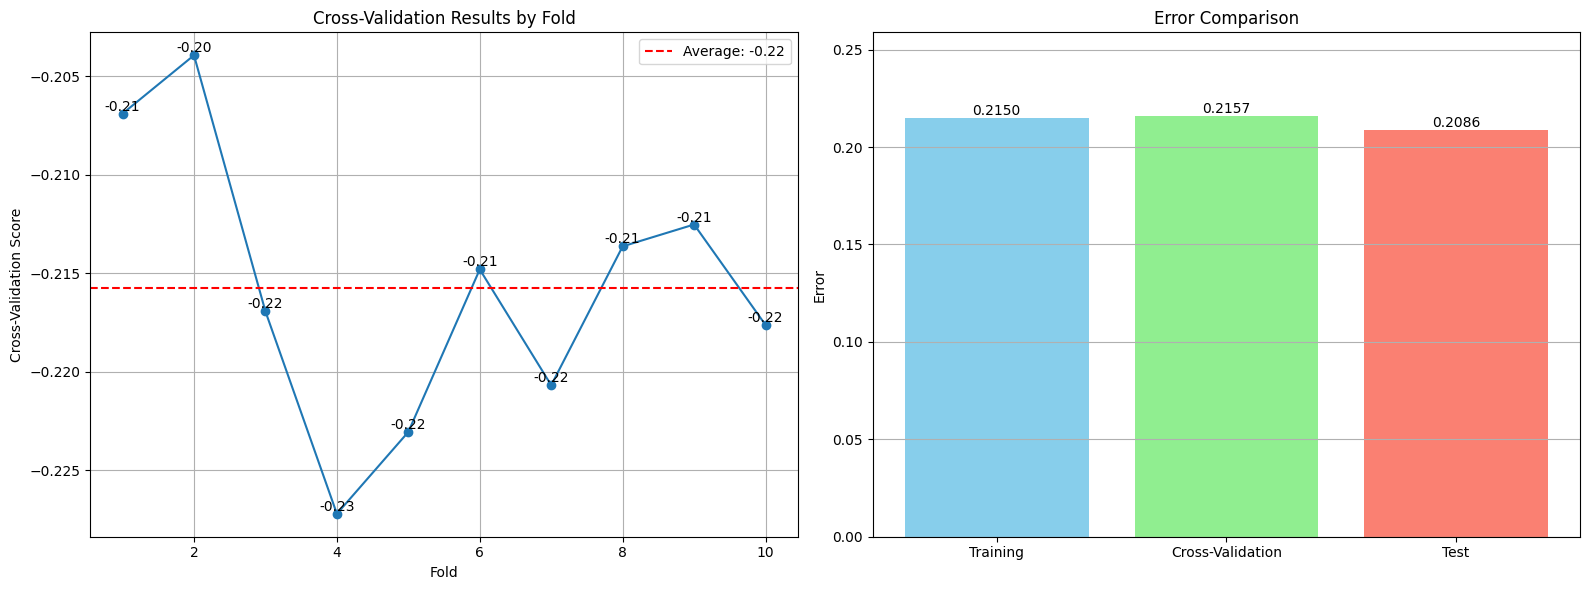

In [26]:
# Define Cross-Validation Parameters
k_folds = 10  # Set the number of folds to 10

# Define Pipeline
pipeline = make_pipeline(
    # StandardScaler(),  
    LinearRegression())  

#fitting data into the model
pipeline.fit(X_train, y_train)
  
# predicting values
y_test_pred = pipeline.predict(X_test)
y_train_pred = pipeline.predict(X_train)

# Perform Cross-Validation
cv_results = cross_val_score(pipeline, X=X_train, y=y_train, cv=k_folds, scoring='neg_mean_squared_error')  # Run cross-validation on training data

# Print Cross-Validation Results
print('Cross-Validation Error for %s folds: \n%s' % (k_folds, -1 * cv_results))  # Display the MSE for each of the 10 folds

# Calculate Average Cross-Validation Error
average_cv = np.mean(cv_results)  # Compute the mean of the cross-validation scores

# Print Average Cross-Validation Error
print('Model Cross-Validation Error: %.3f +/- %.3f' % (-1 * average_cv, np.std(cv_results)))  # Display mean CV error and standard deviation

# Calculate Model Errors
error_train = mean_squared_error(y_train, y_train_pred)  # Compute MSE for training predictions
error_test = mean_squared_error(y_test, y_test_pred)  # Compute MSE for test predictions
error_cv = -1 * np.mean(cv_results)  # Compute average CV error (convert negative MSE to positive)

# Print Model Errors
print('Training Model Error: %.4f' % error_train)  # Display training MSE
print('Cross-Validation Model Error: %.4f' % error_cv)  # Display cross-validation MSE
print('Test Model Error: %.4f' % error_test)  # Display test MSE

# Create Figure with Two Subplots Side by Side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # Create a figure with two subplots, total size 16x6 inches

# Create Cross-Validation Line Plot
folds = np.arange(1, len(cv_results) + 1)  # Generate an array of fold indices (1 to 10)
ax1.plot(folds, cv_results, marker='o', linestyle='-')  # Plot CV scores with markers and lines
ax1.set_title('Cross-Validation Results by Fold')  # Set the title for the line plot
ax1.set_xlabel('Fold')  # Label the x-axis as Fold
ax1.set_ylabel('Cross-Validation Score')  # Label the y-axis as Cross-Validation Score
ax1.grid(True)  # Add a grid to the plot
for i, result in enumerate(cv_results):  # Iterate over CV results
    ax1.text(folds[i], result, f'{result:.2f}', ha='center', va='bottom')  # Add text label with the score above each point
ax1.axhline(y=average_cv, color='r', linestyle='--', label=f'Average: {average_cv:.2f}')  # Draw a dashed red line for the mean CV score
ax1.legend()  # Display the legend

# Create Error Comparison Bar Plot
labels = ['Training', 'Cross-Validation', 'Test']  # Set labels for training, CV, and test
errors = [error_train, error_cv, error_test]  # List of errors for each category
ax2.bar(labels, errors, color=['skyblue', 'lightgreen', 'salmon'])  # Create bars with different colors for each category
ax2.set_title('Error Comparison')  # Set the title for the bar plot
ax2.set_ylabel('Error')  # Label the y-axis as Error
ax2.set_ylim(0, max(errors) * 1.2)  # Set y-axis limit to 120% of the maximum error for better visibility
ax2.grid(axis='y')  # Add a horizontal grid to the plot
for i, error in enumerate(errors):  # Iterate over errors
    ax2.text(i, error, f'{error:.4f}', ha='center', va='bottom')  # Add text label with the error value above each bar

# Adjust Layout and Display Plots
plt.tight_layout()  # Adjust spacing between subplots to prevent overlap
plt.show()  # Render the figure with both plots

By adding more variables to our model, the MSE is significantly reduced compared to the previous model with fewer variables. It went from an MSE on the order of 0.37 to an error on the order of 0.22 (a 40% reduction). This suggests that the model is improving with the addition of variables.

Additionally, we have a standard deviation of 0.007, with an average of 0.217. This suggests that the model is fitting well, as there is not much variation between the different MSE values for the folds.

The errors in train, test, and CV are very similar. This suggests that the model is fitting well. There is no evidence of overfitting, nor of underfitting, as the MSE decreased compared to the simpler model.

## 5. Ridge and Lasso regularization

This section introduces regularized regression models—Ridge and Lasso—and compares their performance against the baseline model through cross-validation and test set evaluation. Key steps include:

- Training Ridge and Lasso models with selected alpha values.
- Performing 10-fold cross-validation to compute mean squared errors for each method.
- Evaluating test set performance for both regularized models.
- Aggregating training, test, and CV errors into a comparative table.
- Visualizing model performance via a bar chart to highlight differences across Ridge, Lasso, and baseline approaches.

This analysis helps assess the trade-offs between regularization strength, generalization capability, and model accuracy. It also reveals how Lasso and Ridge contribute to predictive stability under multicollinearity or high-dimensional data settings. Let me know if you’d like to run this for different alpha values or visualize coefficient paths.


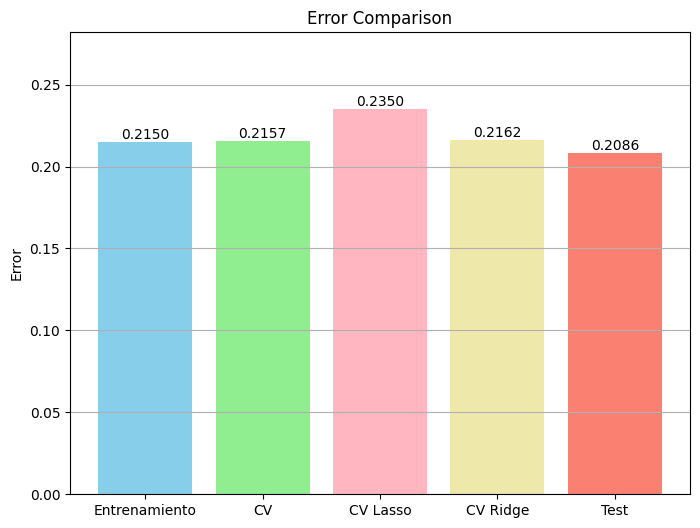

In [27]:
# Train Ridge Model and Perform Cross-Validation
ridge = Ridge(alpha=100)  # Initialize Ridge model with alpha=100
ridge_cv_scores = cross_val_score(ridge, X_train, y_train, cv=10, scoring='neg_mean_squared_error')  # Run 10-fold cross-validation for Ridge

# Train Ridge and Evaluate on Test Set
ridge.fit(X_train, y_train)  # Fit Ridge model on training data
y_pred_ridge_test = ridge.predict(X_test)  # Predict on test set
ridge_mse_test = mean_squared_error(y_test, y_pred_ridge_test)  # Compute test MSE for Ridge

# Train Lasso Model and Perform Cross-Validation
lasso = Lasso(alpha=0.01)  # Initialize Lasso model with alpha=0.01
lasso_cv_scores = cross_val_score(lasso, X_train, y_train, cv=10, scoring='neg_mean_squared_error')  # Run 10-fold cross-validation for Lasso

# Train Lasso and Evaluate on Test Set
lasso.fit(X_train, y_train)  # Fit Lasso model on training data
y_pred_lasso_test = lasso.predict(X_test)  # Predict on test set
lasso_mse_test = mean_squared_error(y_test, y_pred_lasso_test)  # Compute test MSE for Lasso

# Calculate Cross-Validation Errors
error_cv_lasso = -1 * np.mean(lasso_cv_scores)  # Compute mean CV MSE for Lasso
error_cv_ridge = -1 * np.mean(ridge_cv_scores)  # Compute mean CV MSE for Ridge

# Create Error Comparison DataFrame
data = {
    'Error Train': [error_train],  # Training MSE from previous model
    'Error CV': [error_cv],  # CV MSE from previous model
    'Error CV Lasso': [error_cv_lasso],  # CV MSE for Lasso
    'Error CV Ridge': [error_cv_ridge],  # CV MSE for Ridge
    'Error Test': [error_test]  # Test MSE from previous model
}
error = pd.DataFrame(data)  # Create DataFrame for error comparison

# Prepare Data for Bar Plot
labels = ['Entrenamiento', 'CV', 'CV Lasso', 'CV Ridge', 'Test']  # Define labels for plot (kept in Spanish as in original)
errors = [error_train, error_cv, error_cv_lasso, error_cv_ridge, error_test]  # List of errors

# Create Error Comparison Bar Plot
plt.figure(figsize=(8, 6))  # Set figure size to 8x6 inches
plt.bar(labels, errors, color=['skyblue', 'lightgreen', 'lightpink', 'palegoldenrod', 'salmon'])  # Create bars with distinct colors
plt.title('Error Comparison')  # Set plot title
plt.ylabel('Error')  # Set y-axis label
plt.ylim(0, max(errors) * 1.2)  # Set y-axis limit to 120% of max error
plt.grid(axis='y')  # Add horizontal grid

# Add Bar Labels
for i, error in enumerate(errors):  # Iterate over errors
    plt.text(i, error, f'{error:.4f}', ha='center', va='bottom')  # Add text label above each bar

# Display Bar Plot
plt.show()  # Render the bar plot

### 5.1 Regularization influence in parameters

#### 5.1.1 Ridge Regularization: Coefficient Path Analysis Across Feature Groups

This section analyzes how Ridge regression penalizes coefficients across a broad alpha range, broken down by feature groups. For each alpha value, the model is trained and its coefficients captured, allowing the visualization of their progression as regularization increases.

The coefficient path plots reveal:

- Which variables retain influence under strong regularization (i.e., large alpha).
- How the importance of each feature varies across groups such as socioeconomic stratum, transportation mode, occupation, and others.
- A visual insight into feature stability and sensitivity—variables that remain non-zero at high alpha may indicate robustness and predictive strength.

This approach aids in identifying which features are consistently informative versus those that are sensitive to penalization, contributing to model interpretability and potential feature selection strategies.


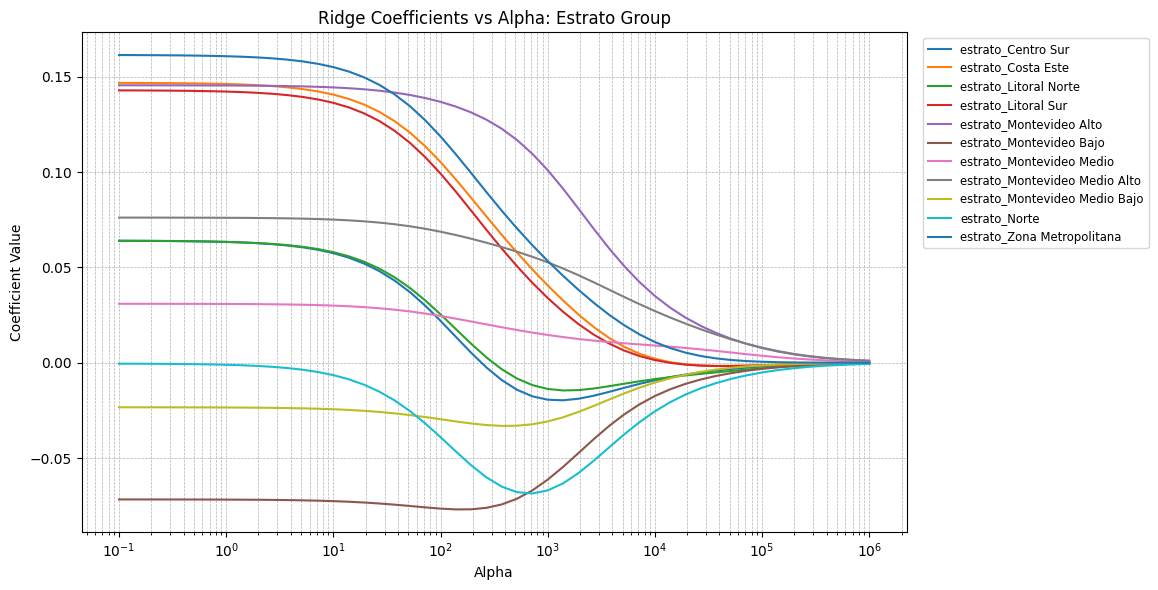

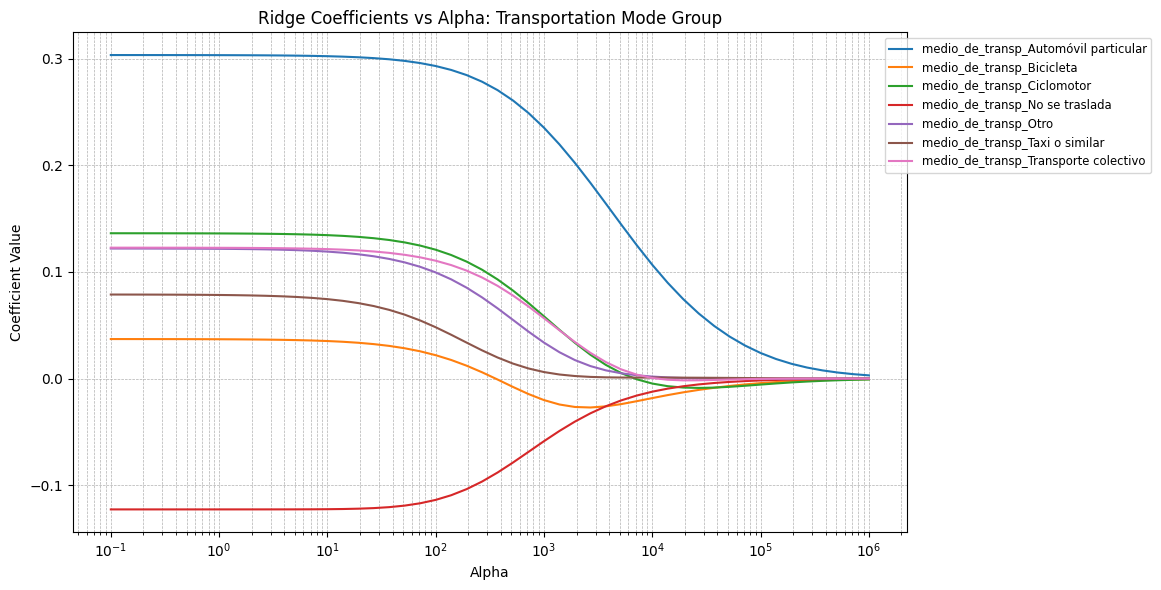

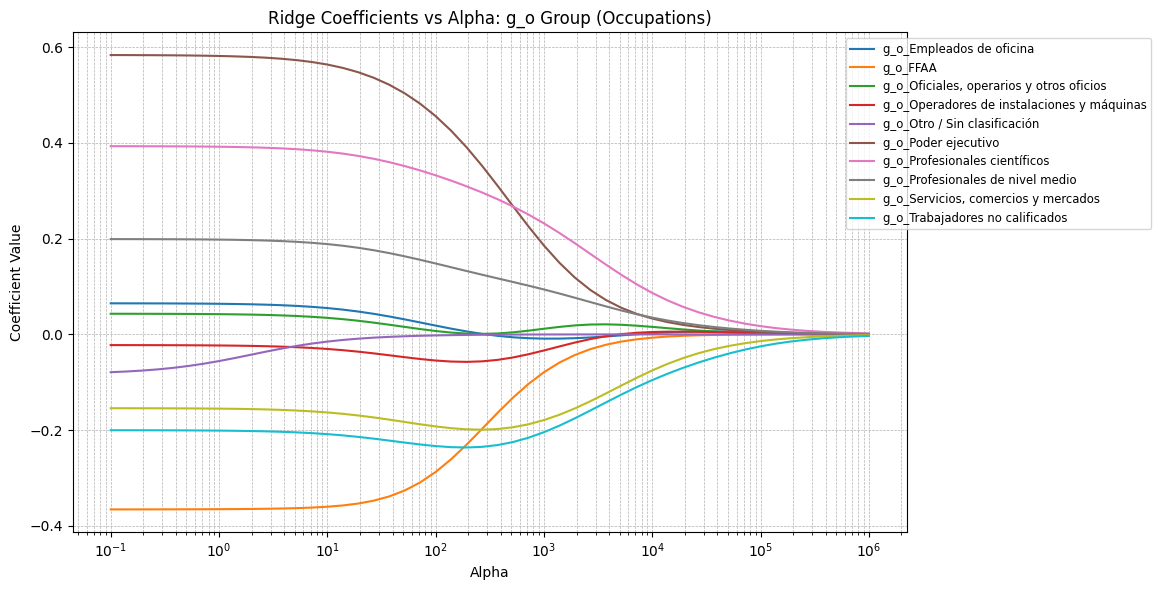

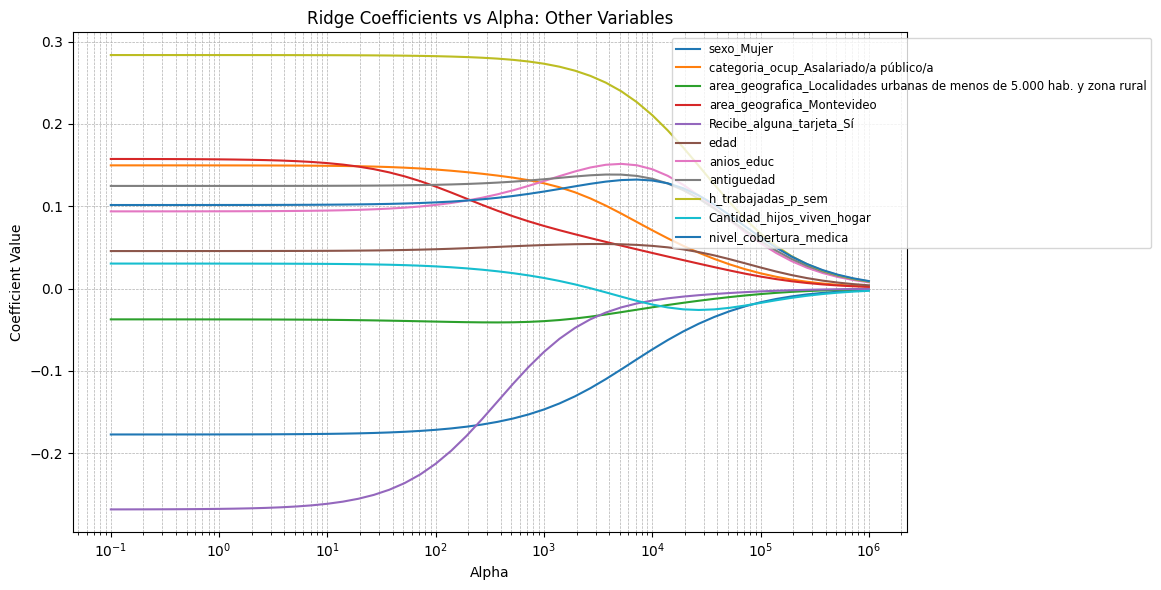

In [28]:
# Ridge
alphas = np.logspace(-1, 6, 50)  # Generate 50 values from 10^-1 to 10^6
ridge_coefs = []

# Calculate training and validation scores for different alpha values using Ridge regression
ridge_train_scores, ridge_val_scores = validation_curve(
    Ridge(), X_train, y_train, param_name="alpha", param_range=alphas, cv=5
)

# Fit a Ridge model for each alpha and store the coefficients
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    ridge_coefs.append(ridge.coef_)

ridge_coefs = np.array(ridge_coefs)

# Create lists of column indices by group
estrato_idx = [i for i, col in enumerate(X.columns) if col.startswith("estrato")]
transp_idx = [i for i, col in enumerate(X.columns) if col.startswith("medio_de_transp")]
go_idx = [i for i, col in enumerate(X.columns) if col.startswith("g_o")]
otros_idx = [i for i, col in enumerate(X.columns)
             if i not in estrato_idx + transp_idx + go_idx]

# Function to plot coefficient paths for a given group of variables
def plot_group(indices, title):
    plt.figure(figsize=(12, 6))
    for i in indices:
        plt.plot(alphas, ridge_coefs[:, i], label=X.columns[i])
    plt.xscale('log')
    plt.xlabel('Alpha')
    plt.ylabel('Coefficient Value')
    plt.title(f'Ridge Coefficients vs Alpha: {title}')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), fontsize='small')
    plt.tight_layout()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

# Plot each group
plot_group(estrato_idx, 'Estrato Group')
plot_group(transp_idx, 'Transportation Mode Group')
plot_group(go_idx, 'g_o Group (Occupations)')
plot_group(otros_idx, 'Other Variables')

#### 5.1.2 Lasso Regularization: Coefficient Path Analysis Across Feature Groups

This section investigates how Lasso regression influences feature selection through coefficient shrinkage across a wide range of alpha values. For each alpha, a model is trained and the resulting coefficients are plotted to visualize the path of penalization.

The groupwise analysis reveals:

- Which features are the first to be discarded as alpha increases, indicating lower relevance or high collinearity.
- Variables that remain active (non-zero coefficients) across broader alpha ranges, suggesting strong predictive contribution.
- The sparsity-inducing nature of Lasso, compared to Ridge, where many coefficients are reduced to exact zeros as regularization intensifies.

This diagnostic helps assess model interpretability and guides dimensionality reduction by identifying influential variables under regularization constraints. It’s especially useful when the goal is to balance predictive performance with model simplicity.


C:\Users\aledi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.925e+02, tolerance: 1.340e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\aledi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.925e+02, tolerance: 1.340e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\aledi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loca

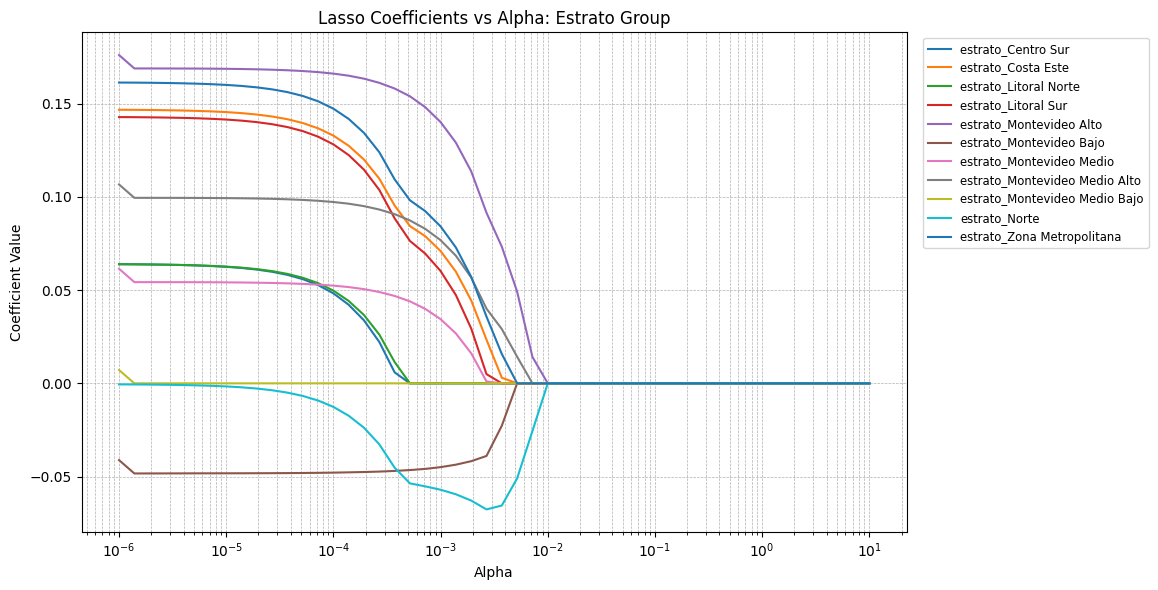

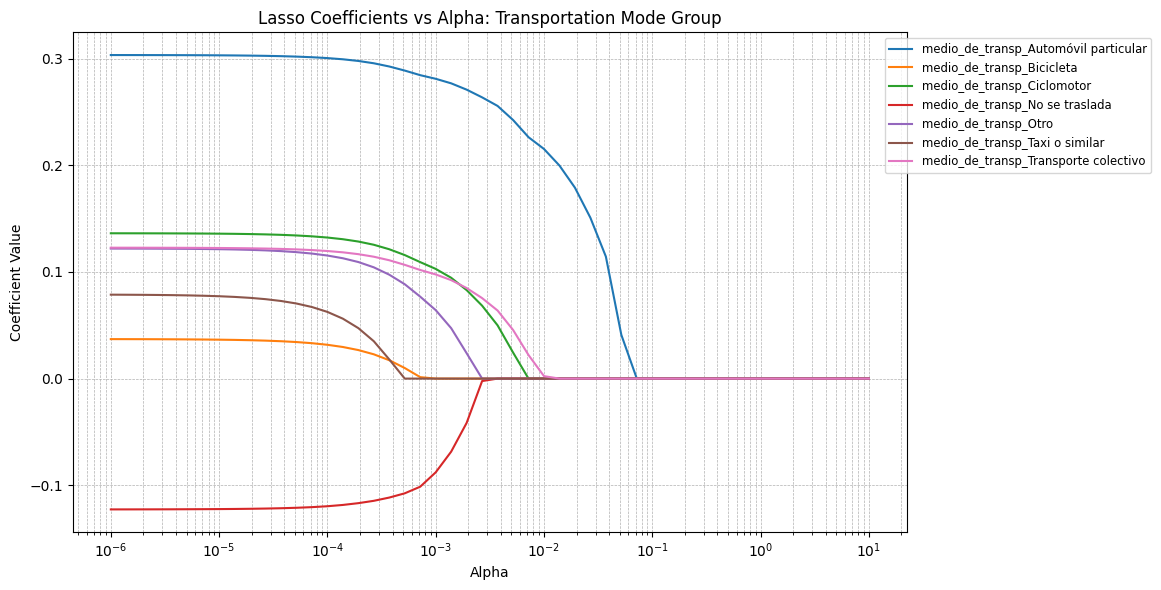

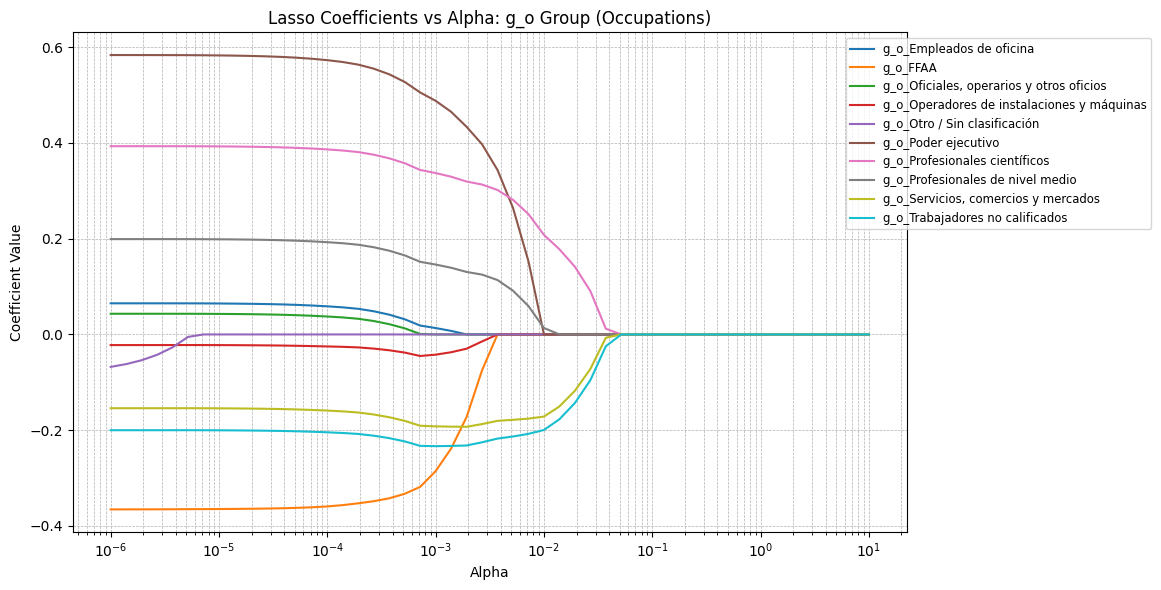

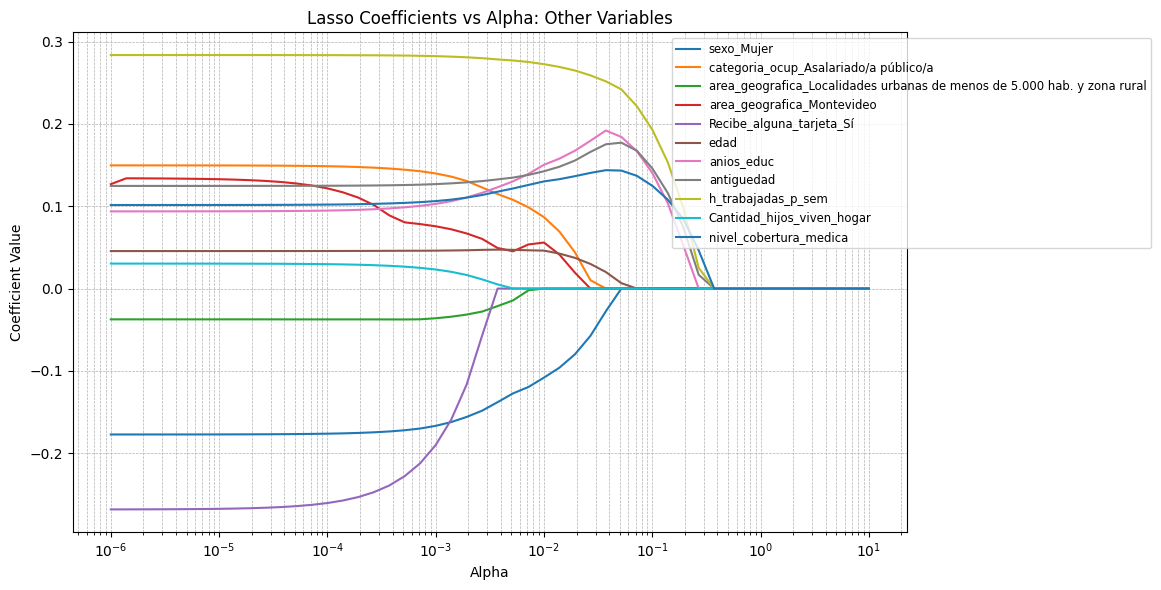

In [29]:
# Lasso
alphas = np.logspace(-6, 1, 50)  # Generate 50 values from 10^-6 to 10^1
lasso_coefs = []

# Calculate training and validation scores for different alpha values using Lasso regression
lasso_train_scores, lasso_val_scores = validation_curve(
    Lasso(), X_train, y_train, param_name="alpha", param_range=alphas, cv=5
)

# Fit a Lasso model for each alpha and store the coefficients
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000, tol=1e-4)
    lasso.fit(X_train, y_train)
    lasso_coefs.append(lasso.coef_)

lasso_coefs = np.array(lasso_coefs)

# Reuse the same plotting function but with Lasso coefficients
def plot_group(indices, title):
    plt.figure(figsize=(12, 6))
    for i in indices:
        plt.plot(alphas, lasso_coefs[:, i], label=X.columns[i])
    plt.xscale('log')
    plt.xlabel('Alpha')
    plt.ylabel('Coefficient Value')
    plt.title(f'Lasso Coefficients vs Alpha: {title}')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), fontsize='small')
    plt.tight_layout()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

# Plot each group
plot_group(estrato_idx, 'Estrato Group')
plot_group(transp_idx, 'Transportation Mode Group')
plot_group(go_idx, 'g_o Group (Occupations)')
plot_group(otros_idx, 'Other Variables')


We observed that both Ridge and Lasso perform variable selection. As the value of alpha increases, some coefficients tend toward zero in the case of Ridge or become exactly zero with Lasso.

In the Beta vs Alpha variation plots, we can assess the importance of each variable. Variables with larger absolute values are more influential. Those that take longer to shrink to zero are more relevant to the model.

At an alpha value of 0.01 in Lasso, a considerable number of coefficients were reduced to zero. Nevertheless, the model achieved a similar MSE to the full model.

This suggests that we can achieve comparable performance with a reduced set of variables. That result can be especially valuable when considering the scalability of the model.
   